# Расчёт размера выборки для конверсии: метод Монте-Карло

АБ-тесты (и вообще проведение исследований) - штука сложная и с кучей подводных камней. И один из важных вопросов, который встаёт перед аналитиком - какой статистический тест подойдёт для конкретной метрики, чтобы получить корректный результат в кратчайшие сроки?

Что такое "корректный результат" - вопрос неоднозначный. Однако свойства конкретного статистического теста вполне можно оценить с помощью симуляций, и на основе полученных результатов сделать выводы о его применимости к конкретной задаче! В этом блокноте я как раз попробую сделать это для конкретной метрики (конверсия) и с использованием нескольких методов, которыми можно проверить изменения в конверсии.

Посмотрим, что из этого получится.

In [1]:
import numpy as np #для симуляций и ряда вспомогательных функций
import pandas as pd #создание датафреймов, имеет вспомогательную роль
import scipy.stats as st #"классические" статметоды и бутстрап
import statsmodels.api as sm #регрессия
import patsy #дизайн-матрицы
import seaborn as sns #отрисовка результатов
from tqdm.auto import tqdm #шкала прогресса

#эта функция создаёт генератор случайных чисел, который пригодится нам для симуляций
rng = np.random.default_rng()

#это уберёт предупреждения, которые могут выкидывать некоторые методы
import warnings
warnings.filterwarnings("ignore")

## 0. Базовые вещи

Если вы дочитали досюда и не закрыли этот документ сразу же, то скорее всего, вы попадаете в мою целевую аудиторию :) Я предполагаю о вас следующие вещи:

- Вы имеете базовое понимание того, как проходят эксперименты и как их результаты проверяются с помощью статистики
- Вы хоть немного владеете языком Python для анализа данных
- Возможно, вы понимаете как минимум часть слов из главного заголовка файла

Тем не менее, я бы хотел на всякий случай пробежаться по базовым идеям, на которых базируется этот пет-проект. Чтобы мы с вами точно были на одной волне и не было недопонимания "а что это и зачем мы это делаем".

### 0.1 Что такое конверсия?

В бизнесе есть немало показателей (метрик), которые в конечном итоге сводятся к бинарному исходу "произошло-не произошло". Перешёл пользователь на сайт или нет? Положил товар в корзину или нет? Купил товар или нет? Приобрёл платную подписку или нет? Обратился в истинную веру или остался грязным еретиком?

Все эти вещи можно назвать общим словом **конверсия (conversion rate)**. Как правило, она выражается в виде доли тех, кто совершил некоторое целевое действие, относительно всех рассматриваемых нами участников исследования. Так, значение конверсии 0.2 может означать, что 20% пользователей приложения хоть раз приобрело платную подписку.

>*ОЧЕНЬ ВАЖНО!* Конверсия предполагает, что на одного пользователя приходится одно действие (или не-действие). У этой метрики есть злой брат-близнец, который чаще всего имеет имя **Click-Through Rate (CTR)**, но может менять название в зависимости от ситуации. Он тоже выражается в виде доли, однако один пользователь может совершить несколько действий. Например, пользователь увидел несколько рекламных объявлений, и на какие-то нажал, а на какие-то нет. Из этого рождается большая статистическая проблема, о которой я поговорю в другом, будущем пет-проекте.

### 0.2 Почему размер выборки важен?

Статистика - это искусство делать вывод о чём-то необозримо большом, имея на руках лишь маленький кусочек этого. Это "необозримо большое" обычно назвается **генеральной совокупностью** (**ГС**, на английском **population**) - все возможные члены того множества, которое нас интересует. Им могут быть все обитатели планеты Земля, все жители России, все потенциальные покупатели и все потенциальные школьники старших классов - зависит от того, что за исследование вы проводите и насколько оно амбициозно.

Однако вы практически никогда не будете иметь на руках всю ГС. Обычно нам приходится ограничиваться лишь её жалким кусочком из тех наблюдений, которые мы смогли собрать для нашего исследования - этот кусочек называется **выборка (sample)**.

Любой исследователь надеется на то, что собранная ими выборка по своим характеристикам такая же, как и ГС. Однако это никогда не гарантировано - люди довольно разные, и вам вполне могут достаться менее репрезентативные представители ГС. Эта вероятность особенно высока, если ваша выборка **небольшая по размеру** - маленькие выборки могут ОЧЕНЬ СИЛЬНО отличаться от того, что происходит в целом в ГС. Этот феномен известен как **вариативность выборок (sampling variation)**.

Однако чем больше вы набираете наблюдений, тем более обстоятельно вы покрываете ГС - и тем выше вероятность, что ваша выборка будет ближе к ГС по своим характеристикам. А значит, по паттернам, которые мы увидим в выборке, мы сможем сделать и более смелое суждение "это справедливо в целом для конкретной ГС".

> Предполагается, что выборка собирается случайным образом - т.е. у каждого представителя ГС одинаковая вероятность оказаться в исследовании. Если вы систематически отбираете в своё исследование только космонавтов, то по их показателям вряд ли разумно делать вывод о всех обитателях Земли. Если вы отбираете только мужчин-космонавтов, то вы вряд ли сможете перенести результаты исследования на женщин-космонавтов. А если вы отбираете только знакомых вам людей, то это вы скорее опишете характеристики своего круга общения, чем сделаете вывод об общих закономерностях.

Значит, чем больше выборка - тем лучше! Но выборку потенциально можно собирать бесконечно - и вы не получите результат, пока не закончится сбор данных. А каждый день без результата - это потенциальная потеря денег для бизнеса. Как понять, в какой момент можно остановиться? Здесь мы должны учесть три фактора.

#### Мощность

У вариативности выборок есть много следствий для результатов исследования. Один из них - это вероятность тупо не найти какую-то закономерность, даже если она реально существует.

> Мы решили оценить, различается ли средний рост у первоклассников и у учеников 11-ого класса. Однако мы собрали не очень большую выборку, и так уж случайно вышло, что среди первоклассников оказались сплошные акселераты, а 11-тиклассники все низкорослые как на подбор. В результате мы не нашли систематических различий в среднем росте - хотя очевидно, что это не так.

Подобный исход известен как **ложноотрицательный результат** или **ошибка II рода**. Мы не хотим часто допускать такие ошибки - любая такая ошибка означает потерю потенциальной прибыли для бизнеса, а бизнесу деньги нужны. Это всё равно что не кинуть спасательный круг утопающему, хотя мы на нём буквально сидим.

Однако в вопросах размера выборки обычно смотрят не на вероятность ошибки II рода, а на комплементарную ей величину - **мощность (power)**. Так, 20%-ая вероятность ошибки II рода означает 80%-ую мощность, а 5%-ая вероятность ошибки II рода - 95%-ую мощность. Иными словами, мощность - это вероятность заметить реально существующий эффект.

Само собой, мы весьма заинтересованы в 100%-ой мощности - и достичь её вполне реально! Но не всегда: 100%-ая мощность может потребовать выборку очень приличных размеров, которую мы себе позволить не можем (либо нам придётся очень долго ждать). В результате приходится идти на компромисс и умерить наши аппетиты по части мощности до некоторого более низкого порога.

Однако компромисс необязательно делать в плоскости "мощность-размер выборки".

#### Размер эффекта

Закономерности бывают разные - большие и маленькие. Некоторые из них видны невооруженным глазом, а некоторые видны только через микроскоп. Выраженность подобных закономерностей называется **размером эффекта (effect size)**. Наиболее распространённая его разновидность - различие в средних между контрольной и тестовой группой, но коэффициент корреляции также считается размером эффекта (насколько сильно взаимосвязаны переменные).

И чем меньше эффект - тем большая выборка нам понадобится, чтобы его заметить.

> Вы наверняка даже с большого расстояния увидите разницу между людьми роста 152 см и роста 201 см. Чтобы различить 178 см и 181 см, вам придётся подойти поближе. А 180.01 см и 180.10 см вы без линейки не различите.

Распространённый термин, используемый в расчётах мощности - это **минимальный обнаруживаемый эффект (Minimum Detectable Effect, MDE)**. Фактически это минимальный размер эффекта, который может быть нам полезен - и который закладывается в расчёты размера выборки. Определяется он путём обсуждений, но хорошая эвристика его выбора такова: это должно быть *минимальное различие, покрывающее затраты на нововведение*.

> Не все эффекты одинаково полезны для всех бизнесов. Допустим, мы обнаружили, что средняя выручка с платящего пользователя в результате нашего нововведения статистически значимо выросла на 1 рубль. Если вы молодая развивающаяся компания, то такой прирост вам погоды не сделает. Но если вы гигантская транснациональная компания с миллионами клиентов, то этот 1 рубль также превратится в миллионы.

Не хватает выборки, но хочется сохранить высокую мощность? Просто поднимите MDE - мелкие эффекты вы тогда не увидите, но так ли они вам нужны?

#### Порог значимости $\alpha$

Ложноотрицательный результат - это, конечно, плохо, погано, фу таким быть. Но напомню, что большая часть статистики танцует вокруг совсем другого типа ошибок - **ложноположительных** или **ошибок I рода**. Иначе говоря, видим различие, а его реально нет (можно и так собрать выборку, да). Для бизнеса это тоже плохо: это всё равно что кинуть утопающему спасательный круг, а он сдутый. Или кинуть вместо круга кирпич.

Если мощность мы хотим побольше, то частоту ложноположительных результатов (**False Positive Rate, FPR**) мы хотим как можно меньше! К сожалению, в отличие от мощности её до нуля понизить нельзя - можно лишь контролировать частоту таких ошибок в долгосрочной перспективе и ошибаться не так часто. 

Напомню, как это работает (в общих деталях):

1. Мы предполагаем, что ничего не изменилось - что такое "ничего", зависит от конкретного теста. Средние в двух группах не различаются. Категориальные переменные независимы. Распределение не отличается от нормального. Вариантов много - и они все называются **нулевой гипотезой** ($H_0$).
2. Из-за вариативности выборок нам недостаточно показать "ну вот, средние в выборках различаются". У каждой нулевой гипотезы есть своё **распределение**, по которому можно понять - какие значения наиболее вероятны при верности данной нулевой гипотезы и насколько они вероятны? Точная форма и характеристики распределения зависят от использованного теста и характеристик выборки.
3. Дальше мы можем посчитать, насколько сильно получившиеся у нас данные **противоречат этой нулевой гипотезе** - эту роль выполняет **p-значение (p-value)**. Фактически это вероятность получить такие же или более выраженные различия при верной нулевой гипотезе - и чем меньше эта вероятность, тем сильнее это противоречие.
4. Мы заранее задаём порог, после которого мы считаем, что противоречие слишком уж сильное - пресловутый **порог статистической значимости**, обозначаемый буквой $\alpha$. После этого наше решение принимает бинарный характер: если p-value выше этого порога, то противоречие недостаточно сильное и мы не отвергаем $H_0$ - и наоборот.
5. Если мы держим порог значимости одинаковым в наших экспериментах, то мы контролируем ошибку I рода на этом уровне значимости - т.е. ложноположительные результаты происходят не чаще, чем указанный порог (для классического 0.05 это 5% ложноположительных результатов).


> Важно ещё раз подчеркнуть, что это долгосрочная перспектива - в классической статистике мы не можем сказать, с какой вероятностью этот конкретный результат ложноположительный. Формализация субъективных убеждений выходит на территорию [байесовской статистики](https://telegra.ph/Bajesovskij-vyvod-10-11).

Какое отношение это имеет к размеру выборки? Чем строже критерий, тем меньше у нас ложноположительных результатов - однако реальные различия мы также будем находить реже, что скажется на размере выборки.

> Представьте себе, что у вас горы зерен, часть из которых заражена. Вы знаете, что в среднем заражённые зёрна крупнее здоровых - однако бывают крупные здоровые зёрна и мелкие заражённые. Нужно собрать килограмм этих зерён - и вы просеиваете их с помощью сита. Более крупнорешётчатое сито будет пропускать больше зерён, но среди них будет больше заражённых. Более мелкорешетчатое сито пропустит меньше заражённых зерён, но и нормальные зерна будет задерживать - в результате вы этот килограмм будете собирать дольше.

### 0.3 В чём суть метода Монте-Карло?

Для расчёта размеров выборки существует ряд онлайн-калькуляторов и готовых функций (например, [тут](https://pingouin-stats.org/build/html/api.html#power-analysis)). Однако тут есть две проблемы:

- Не для всех тестов существует формула расчёта выборки - если для вашего теста её не придумали, то вы в пролёте
- Формулы предполагают идеальный случай для конкретного теста, когда соблюдены всё допущения - однако не всегда можно сказать, будут ли эти допущения реально соблюдаться

Так что же делать? Ответ простой: нам нужно всего лишь

**С Т А Т Ь   Б О Г О М**

На самом деле всё не так эпично: нам нужно просто воссоздать ситуацию, имитирующую многократное проведение теста, и посчитать наши показатели на основе этих повторов. Этот подход называется **методом Монте-Карло**, с его помощью можно посчитать минимальный необходимый размер выборки для любых данных и любого теста!

Как он работает (в общих чертах):

1. Генерируем две выборки определённого размера, которые различаются в чём-то между собой
2. Сравниваем их интересующим нас тестом
3. Сохраняем p-value
4. Повторяем пункты 1-3 много раз
5. Считаем, в скольких случаях было обнаружено статистически значимое различие - это будет значением **мощности теста**


Если нас не устраивает полученное значение мощности, то делаем одну из трёх вещей:

- Меняем размер выборки - чем больше выборка, тем выше должна быть мощность. Соответственно, в реальном А/Б-тесте вам понадобится выборка большего размера, чтобы обнаружить такие различия.
- Меняем величину различий между генеральными совокупностями - чем они больше, тем выше должна быть мощность. Соответственно, в реальном А/Б-тесте вам понадобится взять больший MDE - эффект меньшего размера мы в таком случае вряд ли поймаем.
- Меняем тест на другой

Вы могли обратить внимание на фразу "должна быть". Если у нас хороший тест и его допущения не нарушаются грубейшим образом, то мощность однозначно будет расти - но если вы вдруг решите так проверять какой-то неадекватный тест из навоза и палок, подобной гарантии не будет :P 

Данные можно полностью симулировать, используя уже описанные статистиками распределения - их существует [довольно много](https://docs.scipy.org/doc/scipy/reference/stats.html#probability-distributions). Минус такого подхода - если реальные данные не ведут себя так, как ведут себя симулированные вами распределения, то расчёты мощности могут быть неточными.

> Более продвинутые аналитики делают симуляции на исторических данных - они собирают массив данных, где не проводилось никаких тестов, после чего берут из них случайные подвыборки. Так как группы берутся из одного распределения и систематически отличаться не должны, то в одной из групп симулируется изменение (например, к каждому значению прибавляется число или значения умножаются на некоторую величину). Пример такого подхода описан [тут](https://medium.com/statistics-experiments/%D0%BA%D0%BE%D0%B3%D0%B4%D0%B0-%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-a-b-%D1%82%D0%B5%D1%81%D1%82-%D1%87%D0%B0%D1%81%D1%82%D1%8C-2-monte-carlo-a342ba5b552c).

Хорошие новости - мы работаем с невероятно примитивной с точки зрения статистики метрикой! Так как конверсия - это набор успехов и неудач, то её легко можно описать одним из простейших распределений в статистике. Встречайте - **распределение Бернулли** (график построен в модуле Distributions программы [JASP](https://jasp-stats.org/)): 

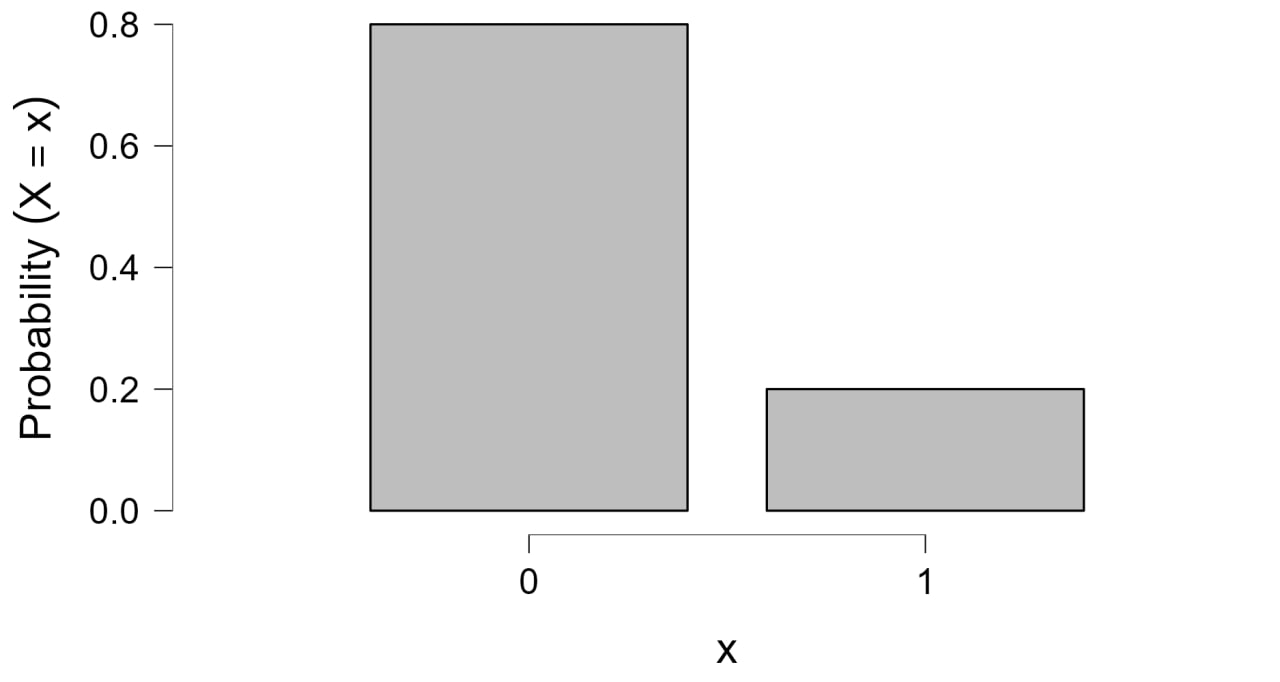

Это распределение имитирует ситуацию, когда с какой-то вероятностью может произойти некоторое событие. Оно может принимать всего две значения (0 и 1) и имеет ровно один параметр - $p$ (вероятность события). Иными словами, идеальный кандидат для симуляции конверсии!

Нагенерировать данные из такого распределения очень легко - всего лишь воспользуйтесь `numpy`:

In [3]:
rng.binomial(n=1, #количество проб - всего одна попытка
             p=0.2, #вероятность успеха <=> величина конверсии
             size=20) #размер выборки

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
      dtype=int64)

Мы можем видеть красивый набор ноликов (событие не произошло) и единичек (событие произошло). Также мы можем посчитать, какое значение конверсии получится на этих данных - для этого нужно:

1. Посчитать количество единичек - это легко делается функцией `sum()`, складывающей все значения в выборке
2. Поделить на размер выборки - в данном случае для расчёта я использую функцию `len()`

In [3]:
conv = rng.binomial(n=1, p=0.2, size=20)
print(f"Выборочное значение конверсии: {sum(conv) / len(conv)}")

Выборочное значение конверсии: 0.2


Попробуйте запустить эту ячейку несколько раз и поменять размер выборки. Вы увидите, что для небольшой выборки значение конверсии скачет туда-сюда, но с ростом её размера конверсия "сойдётся" к истинному значению.

Вы могли обратить внимание, что функция для генерации этих значений называется вовсе не `bernoulli` - она называется `binomial`. Это потому, что распределение Бернулли - частный случай **биномиального распределения**:

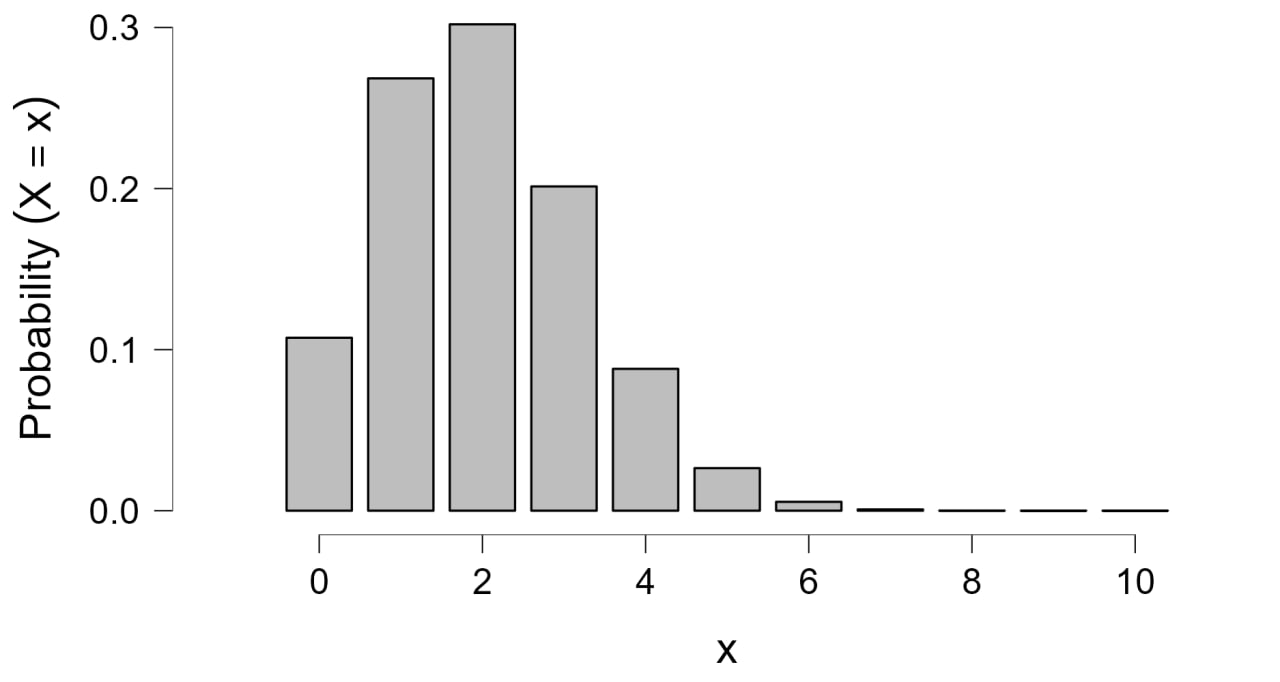

Это распределение показывает, сколько раз произошло событие в заданном количестве проб. Распределение Бернулли - это случай, когда проба всего одна, но их может быть много!

Соответственно, вместо череды ноликов и единичек мы можем просто сразу сгенерировать количество успехов, а потом вычесть его из количества проб и получить количество неудач. Вот так:

In [4]:
rng.binomial(n=20, p=0.2, size=1)[0]

5

В зависимости от контекста симуляции может быть удобнее как генерировать череду ноликов-единичек, так и количество успехов. В этом ноутбуке я чаще буду использовать первый вариант, так как он ближе к тому, как выглядят "сырые" данные конверсии - для некоторых методов подойдёт только такой подход.

Так давайте же приступим к симуляциям!

## 1. Хи-квадрат

Первым на очереди идёт классический тест, рекомендуемый для анализа категориальных данных - тест хи-квадрат! У него есть [несколько разновидностей](https://habr.com/ru/companies/mygames/articles/677074/), но нас в данном случае интересует **тест на независимость переменных (chi-square independence test)** - наиболее известный способ анализа **таблиц сопряжённости (contingency table)**.

Типичная таблица сопряжённости выглядит так:

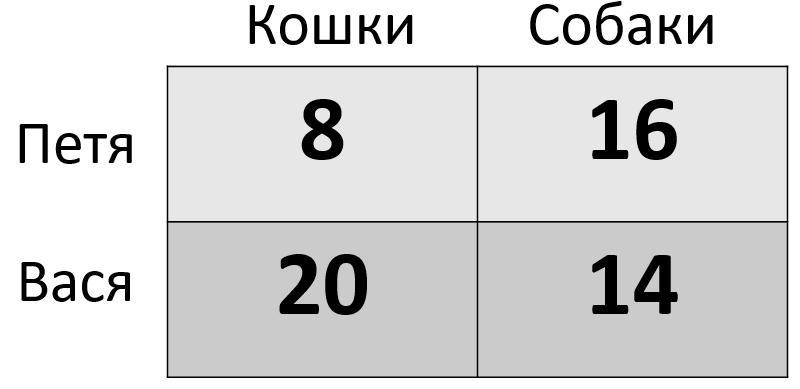

Перед вами - теоретические данные некоторых Пети и Васи, которые ОЧЕНЬ любят животных и держат у себя дома зверинец. По этой таблице легко можно увидеть, что у Пети больше собак, чем у Васи - а у Васи больше кошек, чем у Пети.

Вопрос: можем ли мы заключить по этой таблице, что предпочтения по животным у Васи и Пети различаются? Или если дать этим безумцам достаточно времени, то их количества кошек и собак уравняются? Иными словами: *есть ли взаимосвязь между переменной кошки/собаки и Петя/Вася*? Именно это и проверяет хи-квадрат.

Как этим проверять конверсию? Для начала нагенерируем данных контрольной и тестовой группы - пусть в контрольной конверсия будет 20%, а в тестовой - 25%:

In [5]:
control = rng.binomial(n=1, p=0.2, size=20)
test = rng.binomial(n=1, p=0.25, size=20)

В этих переменных - "сырые" значения для целевых действий, нолики и единички. Но чтобы сравнить эти две группы с помощью хи-квадрата, нам нужно создать кое-что в помощь - переменные, обозначающие принадлежность конкретных данных к конкретной группе.

In [6]:
control_idx = np.repeat(0, repeats=20) #повторяем 0 столько же раз, сколько наблюдений в контрольной группе
control_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
test_idx = np.repeat(1, repeats=20) #делаем похожее для тестовой группы
test_idx

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

А теперь из этого можно сделать две переменные - одна будет содержать информацию о том, что это за группа, вторая - какие данные были зарегистрированы в этой группе:

In [8]:
data = np.concatenate([control, test])
group = np.concatenate([control_idx, test_idx])

In [10]:
data #данные

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int64)

In [11]:
group #группы

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Если перекинуть их в датафрейм, то мы получим типичный вид таблички с данными:

In [12]:
pd.DataFrame({"Group":group, "Data":data}).head()

,Group,Data
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0


In [13]:
pd.DataFrame({"Group":group, "Data":data}).tail()

,Group,Data
35,1,1
36,1,0
37,1,0
38,1,1
39,1,0


Наконец, из этих двух переменных можно построить таблицу сопряжённости:

In [14]:
cont_matrix = st.contingency.crosstab(group, data).count
cont_matrix

array([[14,  6],
       [16,  4]])

Какую табличку сопряжённости мы получили на этот раз? Вот такую (при перезапуске может получиться чуть иная):

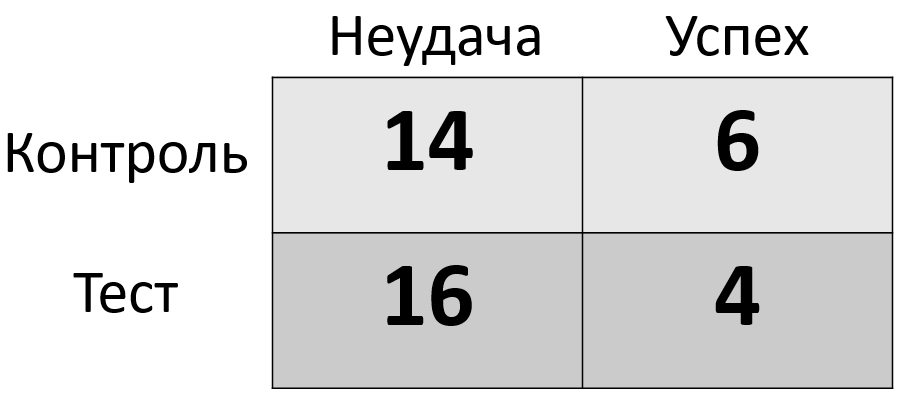

Можем ли мы сказать по ней, что распределения успехов и неудач отличаются в двух группах? А об этом нам и скажет хи-квадрат:

In [15]:
st.chi2_contingency(cont_matrix)

Chi2ContingencyResult(statistic=0.13333333333333333, pvalue=0.7150006546880892, dof=1, expected_freq=array([[15.,  5.],
       [15.,  5.]]))

P-value у нас оказалось ощутимо выше 0.05, соответственно, мы не можем отвергнуть $H_0$. Означает ли это, что нововведение в тестовой группе никак не повлияло на конверсию? Конечно же, нет - мы достоверно знаем, что в тестовой группе конверсия выше! Нам просто не хватило мощности, чтобы поймать этот эффект.

Так давайте же считать эту мощность симуляциями! Ниже - функция, которая позволит нам это сделать:

In [2]:
def chi_power(conv_control, conv_test, sample_size, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для теста хи-квадрат методом Монте-Карло (независимые наблюдения, равный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (одна группа)
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=sample_size) #данные тестовой группы

        data = np.concatenate([control, test]) #общая переменная с данными групп
        group = np.concatenate([np.repeat(0, repeats=sample_size), 
                                np.repeat(1, repeats=sample_size)]) #индикаторы принадлежности наблюдения к группе

        #на основе полученных данных строим таблицу сопряженности
        #используем тест хи-квадрат, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.chi2_contingency(st.contingency.crosstab(group, data).count).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Давайте допустим, что мы набрали не настолько мизерную выборку 20/20, а вполне серьёзную 1000/1000! Прогоним эту симуляцию 10000 раз, чтобы получить более точное значение. Что мы получим?

In [3]:
chi_res = chi_power(conv_control=0.2, conv_test=0.25, sample_size=1000, num_iter=10000, rng=rng)
print(f"Значение мощности: {chi_res}")

Значение мощности: 0.7527


Примерно в 75% симуляций тест хи-квадрат смог найти различия между выборками - иными словами, мощность нашего теста составляет 75%! Если нам этого мало, то мы можем увеличить размер выборок - или величину различий между конверсиями в группах. При очень большом желании можно поднять ещё порог значимости, но это плохая идея - разве что вы реально не боитесь ошибок I рода.

Мы также можем посмотреть, как меняется мощность в зависимости от размера выборки! Это будет полезно для сравнения с другими методами:

In [4]:
chi_powers = [] #сюда будем складывать значения мощности

for sample_size in tqdm(range(20, 1100, 20)): #размеры выборок от 20 до 1080 в каждой группе

    chi_powers.append(chi_power(conv_control=0.2, conv_test=0.25, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

Положим результат в датафрейм и нарисуем его:

<Axes: xlabel='Sample', ylabel='Power'>

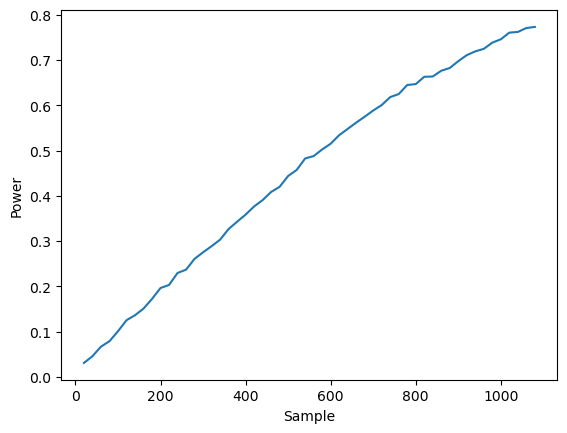

In [5]:
chi_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":chi_powers})
chi_results["Method"] = "Chisquare"
sns.lineplot(data=chi_results, x="Sample", y="Power")

Видим чёткий линейный рост мощности с размером выборки - ближе к концу он замедляется, но этого стоило ожидать. Всё-таки у мощности потолок в 1.0, и любая линия в какой-то момент изогнётся.

Можем ли мы сделать лучше?

## 2. t-тест

T-тест - это другой классический тест, который учат одним из первых. Он хорошо выполняет простую задачу - сравнивает средние в группах. Какое отношение это имеет к конверсии? 

Давайте ещё раз вспомним, как мы считали конверсию в выборках:

1. Посчитать количество единичек - это легко делается функцией `sum()`, складывающей все значения в выборке
2. Поделить на размер выборки - в данном случае для расчёта я использую функцию `len()`

Какая у нас формула для среднего?

$$\mu = \frac{\sum_{i = 1}^{N}{X_i}}{N}$$

Буквально то же самое - суммировать все значения и поделить на количество! Так мы узнали, что пропорция - это частный случай среднего (возможно, вы узнали это раньше, если внимательно поизучали код прошлой функции).

Возникает вопрос: а можно ли тогда сравнивать наши группы t-тестом? Во многих учебниках t-тест всё-таки применяют на непрерывных распределениях - не сломается ли он на данных конверсии?

Сейчас мы это и узнаем.

In [6]:
def t_power(conv_control, conv_test, sample_size, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для t-теста методом Монте-Карло (независимые наблюдения, равный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (одна группа)
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=sample_size) #данные тестовой группы

        #используем t-тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.ttest_ind(control, test, equal_var=False).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [7]:
t_res = t_power(conv_control=0.2, conv_test=0.25, sample_size=1000, num_iter=10000, rng=rng)
print(f"Значение мощности: {t_res}")

Значение мощности: 0.7568


Можем видеть, что при тех же условиях t-тест как минимум справляется не хуже, а то и чуть лучше! 

In [8]:
power_t = []

for sample_size in tqdm(range(20, 1100, 20)):

    power_t.append(t_power(conv_control=0.2, conv_test=0.25, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

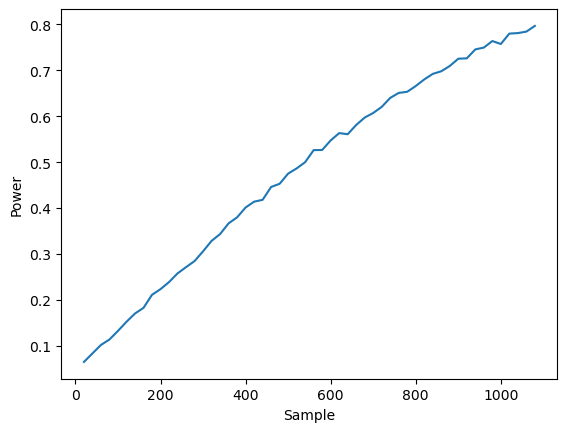

In [9]:
t_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":power_t})
t_results["Method"] = "T-test"
sns.lineplot(data=t_results, x="Sample", y="Power")

Видим похожий линейный рост. Как он соотносится с прошлым графиком?

In [10]:
total_df = pd.concat([chi_results, t_results])

<Axes: xlabel='Sample', ylabel='Power'>

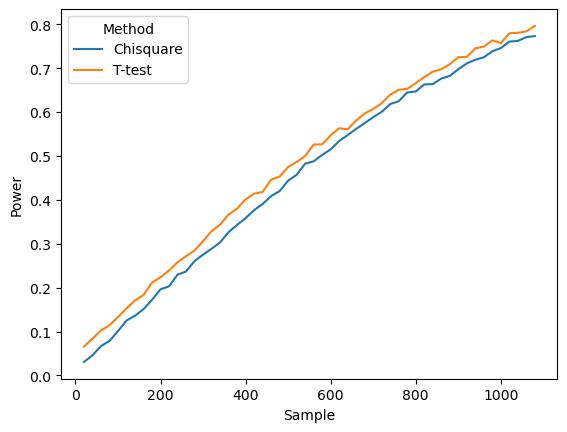

In [11]:
sns.lineplot(data=total_df, x="Sample", y="Power", hue="Method")

Вот это да! T-тест мало того что не ломается на таких данных - его мощность систематически выше мощности хи-квадрата! Это означает, что мы можем чуточку сэкономить на размерах выборки - и обнаруживать эффект чуть чаще при прочих равных. Похоже, что пока t-тест побеждает в состязании тестов!

Можем ли мы ещё что-то проверить?

## 3. Bootstrap

"В любой непонятной ситуации используйте бутстрап" (с) кто-то там

Бутстрап - порождение современной статистики, родственное методу Монте-Карло: он также построен на симуляциях! Хотя у бутстрапа есть [много разновидностей](https://influentialpoints.com/Training/bootstrap_confidence_intervals-principles-properties-assumptions.htm), большая их часть подчиняется общему принципу:

1. Берём данные
2. Берём из них подвыборку того же размера *с возвращением* (это важно!)
3. Считаем нужный показатель на получившейся подвыборке
4. Повторяем процедуру много раз
5. Строим доверительный интервал на основе получившегося распределения

Что означает взятие выборки *с возвращением*? Это значит, что каждое значение может быть взято больше одного раза - а может быть не взято вообще. В результате каждая такая симуляция создаёт своего рода "кривое зеркало" оригинальной выборки - распределение, которое будто бы похоже на оригинал, но чуточку отличается (а то и не чуточку). Считая на основе этих выборок интересующий нас показатель, мы узнаём, насколько сильно он варьирует в зависимости от изменений в данных - и на основе этого мы также можем делать статистический вывод.

Магия бутстрапа в том, что технически он может так делать с абсолютно любым показателем. Хотели когда-нибудь посмотреть на доверительный интервал стандартного отклонения? Он это легко может сделать. Однако подобная гибкость имеет страшную цену: бутстрап **чудовищно медленный**. Из-за этого к нему часто прибегают как к Инструменту Судного Дня, когда больше ничего не работает.

Как бутстрап справится с задачей сравнения средних на наших данных? Давайте посмотрим.

In [23]:
def boot_power(conv_control, conv_test, sample_size, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для бутстрапа средних методом Монте-Карло (независимые наблюдения, равный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (одна группа)
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in tqdm(range(num_iter)):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=sample_size) #данные тестовой группы

        res = st.bootstrap(data=(control, test), #сравниваемые группы
                           statistic=lambda a, b: np.mean(a) - np.mean(b), #статистика - различия в средних
                           n_resamples=1000, #количество бут-повторений - сделаем поменьше, чтобы работало побыстрее
                           confidence_level=1-alpha) #границы доверительного интервала
        signs = np.sign(res.confidence_interval) #возвращаем знаки каждой границы интервала (плюс или минус)

        #нам нужно, чтобы доверительный интервал не пересекал 0
        #это значит, что либо обе границы положительные, либо обе границы отрицательные
        pvals.append(int(signs[0]) == int(signs[1]))

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [24]:
boot_res = boot_power(conv_control=0.2, conv_test=0.25, sample_size=1000, num_iter=10000, rng=rng)
print(f"Значение мощности: {boot_res}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Значение мощности: 0.7576


Результат выглядит сравнимым с t-тестом. Однако если для t-теста это значение считалось 5 секунд, то бутстрап потребовал *42 минуты*.

Человеческий век короток, а я не молодею. Поэтому на этом моменте я дисквалифицирую бутстрап как метод, который того не стоит. Если у вас будет желание и время, чтобы погонять бутстрап у себя и посчитать его характеристики в различных ситуациях - you are welcome, можете взять код выше и адаптировать его под свою задачу! 

## 4. Неравные размеры выборок

По умолчанию в классических экспериментах подразумевается, что размеры выборок у нас одинаковы. Но в жестокой практике этот идеал не всегда достижим.

> Представьте себе, что мы выкатили обновление на половину наших клиентов, и оно вышло ужасным. Настолько, что эти клиенты просто перестали пользоваться нашими услугами, и бизнес потерял огромное количество денег. Страшная ситуация, не правда ли?

Поэтому для перестраховки часто вводят неодинаковые размеры выборок - большую часть пользователей определяют в контрольную группу, и лишь небольшой сегмент определяют в тестовую. Таким образом, даже если эксперимент закончится оглушительным провалом, это навредит бизнесу в гораздо меньшей степени.

Однако как такой дизайн эксперимента отразится на мощности? Посмотрим на примере хи-квадрата и t-теста.

In [12]:
#пропорции от 100% до 5%

props = np.flip(np.arange(0.05, 1.05, 0.05))
props

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05])

Допустим, что размер контрольной группы у нас составляет 1000, а размер тестовой составляет некоторую долю от контрольной. Выше я сгенерировал несколько таких долей - начиная от 1 (одинаковые размеры групп) до 0.05 (50 человек в тестовой группе).

Модифицируем наши изначальные функции:

In [13]:
def chi_power_uneq(conv_control, conv_test, sample_size, test_prop, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для теста хи-квадрат методом Монте-Карло (независимые наблюдения, неравный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (контрольная группа)
    * test_prop - какую пропорцию составляет размер тестовой группы от размера контрольной
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=round(sample_size*test_prop)) #данные тестовой группы

        #общая переменная с данными групп
        data = np.concatenate([control, test]) 
        #индикаторы принадлежности наблюдения к группе
        group = np.concatenate([np.repeat(0, repeats=sample_size), 
                                np.repeat(1, repeats=round(sample_size*test_prop))])

        #на основе полученных данных строим таблицу сопряженности
        #используем тест хи-квадрат, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.chi2_contingency(st.contingency.crosstab(group, data).count).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [14]:
power_chi_uneq = []

for prop in tqdm(props):

    power_chi_uneq.append(chi_power_uneq(conv_control=0.2, conv_test=0.25, sample_size=1000, 
                                         test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

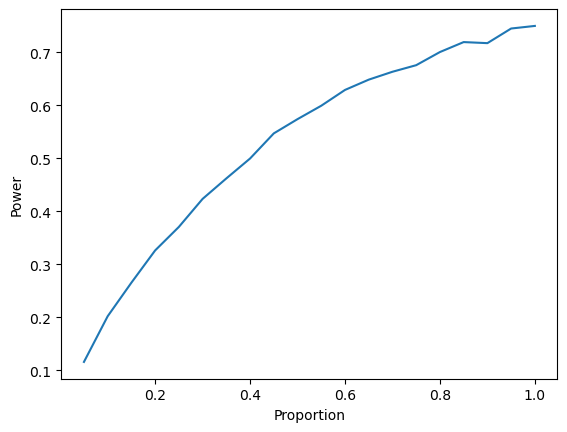

In [15]:
chi_uneq_results = pd.DataFrame({"Proportion":props, "Power":power_chi_uneq})
chi_uneq_results["Method"] = "Chisquare (uneq. samples)"
sns.lineplot(data=chi_uneq_results, x="Proportion", y="Power")

Видно, что диспропорция в размерах выборок очень больно бьёт по мощности - и чем больше разрыв, тем сильнее падает мощность!

In [16]:
def t_power_uneq(conv_control, conv_test, sample_size, test_prop, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для t-теста методом Монте-Карло (независимые наблюдения, неравный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (контрольная группа)
    * test_prop - какую пропорцию составляет размер тестовой группы от размера контрольной
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=round(sample_size*test_prop)) #данные тестовой группы

        #используем t-тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.ttest_ind(control, test, equal_var=False).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [17]:
power_t_uneq = []

for prop in tqdm(props):

    power_t_uneq.append(t_power_uneq(conv_control=0.2, conv_test=0.25, sample_size=1000, 
                                     test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

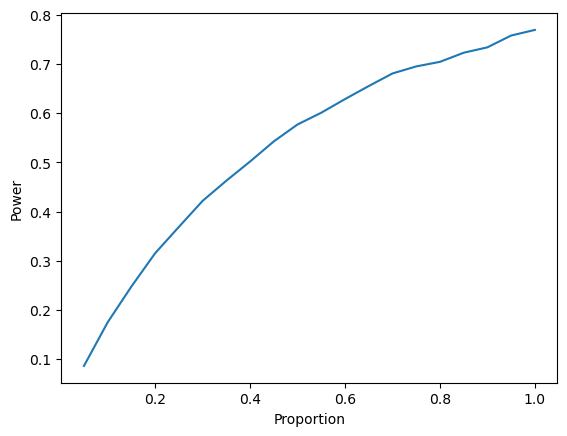

In [18]:
t_uneq_results = pd.DataFrame({"Proportion":props, "Power":power_t_uneq})
t_uneq_results["Method"] = "T-test (uneq. samples)"
sns.lineplot(data=t_uneq_results, x="Proportion", y="Power")

Здесь похожая ситуация. Как соотносятся эти кривые?

<Axes: xlabel='Proportion', ylabel='Power'>

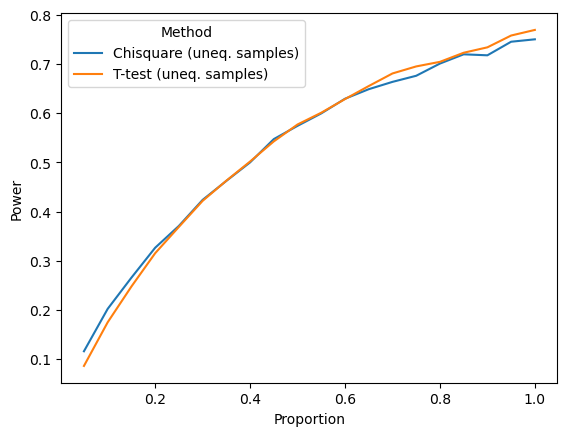

In [19]:
total_df_uneq = pd.concat([chi_uneq_results, t_uneq_results])
sns.lineplot(data=total_df_uneq, x="Proportion", y="Power", hue="Method")

Ещё более неожиданный результат!

- Когда выборки равны по размерам, t-тест превосходит хи-квадрат по мощности
- Однако чем выше диспропорция в размерах выборок, тем более схожи мощности двух методов
- При особо сильных диспропорциях хи-квадрат даже превосходит t-тест по мощности

То есть хи-квадрат всё-таки не совсем бесполезен! Если жизнь загоняет нас в ситуацию неравенства размеров выборок, то выбрать хи-квадрат для конверсии оказывается неплохой идеей.

Осталось проверить ещё одну важную вещь.

## 5. Контроль ошибки I рода

Выше мы смотрели на то, насколько хорошо тест обнаруживает различие там, где оно есть. Но можно задать закономерный вопрос - насколько хорошо тест НЕ обнаруживает ложных различий? Иначе говоря, насколько он хорошо контролирует частоту ошибок I рода?

Мы можем проверить это так же, как и мощность - просто генерировать выборки с одинаковым значением конверсии, а не разным. Соответственно, все обнаруженные нами различия будут ложноположительными! На уровне значимости 0.05 FPR (т.е. процент ошибок I рода) должен составлять примерно 5%.

- Если процент ошибок систематически ниже, то такой тест называют **консервативным**
- Если процент ошибок систематически выше, то такой тест называют **либеральным**

Проверим, насколько хороши в этом плане хи-квадрат и t-тест. Также узнаем, влияет ли на это различие в размерах выборок?

In [20]:
chi_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    chi_fpr.append(chi_power(conv_control=0.2, conv_test=0.2, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

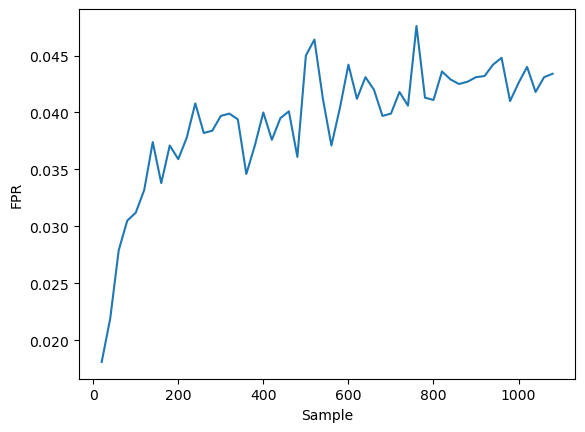

In [21]:
chi_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":chi_fpr})
chi_fpr_results["Method"] = "Chisquare"
sns.lineplot(data=chi_fpr_results, x="Sample", y="FPR")

Явно видно, что хи-квадрат консервативен - его FPR находится в районе 4-4.5%, что ниже заявленных 5%. Для малых размеров выборок он оказывается даже ещё консервативнее - FPR в районе 2%.

In [22]:
t_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_fpr.append(t_power(conv_control=0.2, conv_test=0.2, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

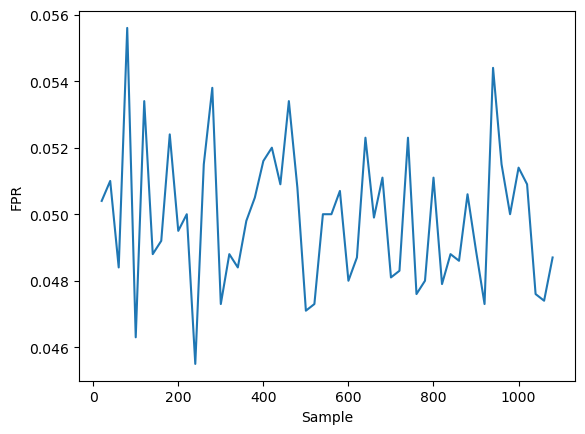

In [23]:
t_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":t_fpr})
t_fpr_results["Method"] = "T-test"
sns.lineplot(data=t_fpr_results, x="Sample", y="FPR")

T-тест же ведёт себя ровно так, как от него просят - его FPR примерно равен 5%. Да, есть колебания, но это следствие конечного числа симуляций - если бы их было бесконечное число, то результаты сошлись бы к 0.05.

Чисто для наглядности сравним эти кривые в одних координатах:

In [24]:
total_fpr_df = pd.concat([chi_fpr_results, t_fpr_results])

<Axes: xlabel='Sample', ylabel='FPR'>

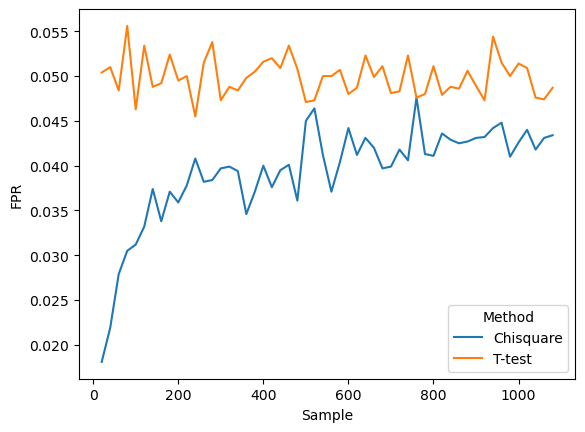

In [25]:
sns.lineplot(data=total_fpr_df, x="Sample", y="FPR", hue="Method")

А что, если размеры выборок не равны?

In [26]:
fpr_chi_uneq = []

for prop in tqdm(props):

    fpr_chi_uneq.append(chi_power_uneq(conv_control=0.2, conv_test=0.2, sample_size=1000, 
                                       test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

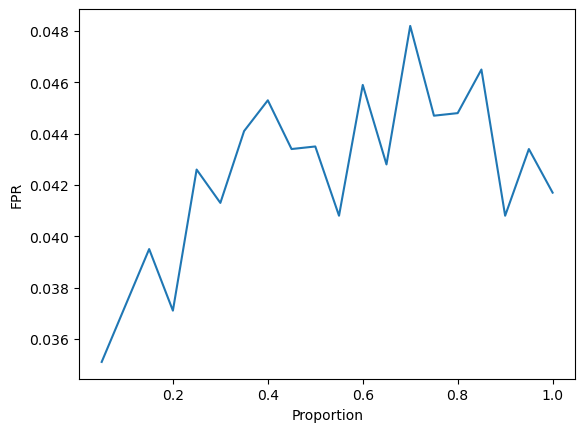

In [27]:
chi_uneq_fpr = pd.DataFrame({"Proportion":props, "FPR":fpr_chi_uneq})
chi_uneq_fpr["Method"] = "Chisquare (uneq. samples)"
sns.lineplot(data=chi_uneq_fpr, x="Proportion", y="FPR")

Судя по всему, увеличение диспропорции делает хи-квадрат ещё консервативнее. А что с t-тестом?

In [28]:
fpr_t_uneq = []

for prop in tqdm(props):

    fpr_t_uneq.append(t_power_uneq(conv_control=0.2, conv_test=0.2, sample_size=1000, 
                                   test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

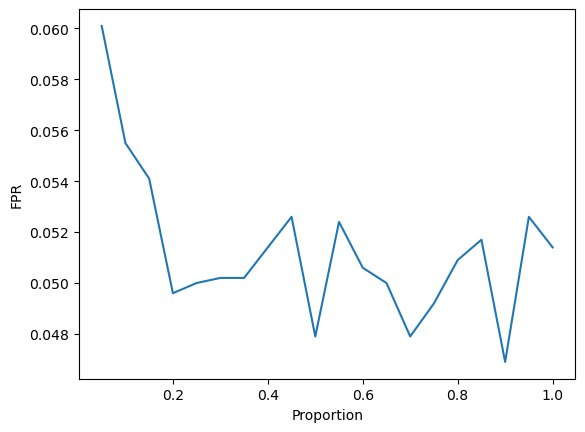

In [29]:
t_uneq_fpr = pd.DataFrame({"Proportion":props, "FPR":fpr_t_uneq})
t_uneq_fpr["Method"] = "T-test (uneq. samples)"
sns.lineplot(data=t_uneq_fpr, x="Proportion", y="FPR")

Опа. Вот мы и наши точку, в которой t-тест реально ломается - мало того, что у него при больших диспропорциях мощность ниже, чем у хи-квадрата, так он ещё и ошибку I рода хуже контролирует: FPR подскакивает до 6%!

Опять же, сравним в одним координатах:

<Axes: xlabel='Proportion', ylabel='FPR'>

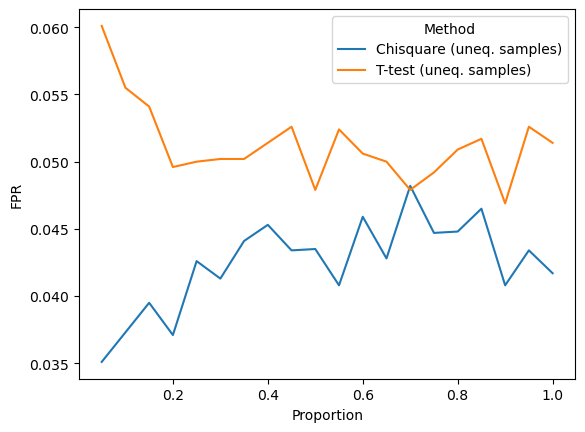

In [30]:
total_fpr_uneq = pd.concat([chi_uneq_fpr, t_uneq_fpr])
sns.lineplot(data=total_fpr_uneq, x="Proportion", y="FPR", hue="Method")

Пока рекомендации выглядят однозначными:

- Если размеры выборок равны - конверсию лучше сравнивать t-тестом
- Если размеры выборок очень сильно различаются - берите хи-квадрат

Закончили ли мы? О нет - нам остался последний, особо фееричный штрих.

## 6. Обобщённые линейные модели

Знаете ли вы, что t-тест - это разновидность линейной регрессии? Это правда - просто прочитайте [этот блогпост](https://lindeloev.github.io/tests-as-linear/) (есть [версия на Python](https://www.georgeho.org/tests-as-linear/)). Многие классические статистические тесты эквивалентны линейной регрессии либо хорошо ей аппроксимируются. Технически большую часть курсов по статистике можно было бы написать силами одной линейной регрессии без ощутимой потери информации.

Давайте сгенерируем выборки побольше и покажем это наглядно.

In [2]:
control = rng.binomial(n=1, p=0.2, size=1000)
test = rng.binomial(n=1, p=0.25, size=1000)

control_idx = np.repeat(0, repeats=1000) 
test_idx = np.repeat(1, repeats=1000) 

data = np.concatenate([control, test])
group = np.concatenate([control_idx, test_idx])

Для начала сравним выборки t-тестом:

In [3]:
st.ttest_ind(control, test)

Ttest_indResult(statistic=-4.94299906260784, pvalue=8.33435844050758e-07)

Мы получили значение тестовой статистики и p-value. Теперь укажем всё то же самое в линейной регрессии:

In [4]:
#функция sm.add_constant() добавляет в регрессию свободный член (константу)
res_ols = sm.OLS(data, sm.add_constant(group)).fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     24.43
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           8.33e-07
Time:                        18:35:53   Log-Likelihood:                -1105.2
No. Observations:                2000   AIC:                             2214.
Df Residuals:                    1998   BIC:                             2226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1870      0.013     14.056      0.000       0.161       0.213
x1             0.0930      0.019      4.943      0.000       0.056       0.130
==============================================================================
Omnibus:                      346.007   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.245
Skew:                           1.237   Prob(JB):                    2.39e-114
Kurtosis:                       2.597   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

За различие в средних у нас отвечает коэффициент x1. И вы можете видеть, что значение t-статстики рядом с ним идентично получившейся ранее! T-статистика тут явно не просто так, как видите :)

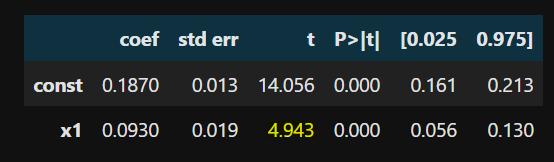

P-value у нас тут вышло мелкое, поэтому оно не отображается полностью. Однако мы всё ещё можем его вывести и сравнить результат:

In [5]:
res_ols.pvalues

array([7.25795413e-43, 8.33435844e-07])

Опять же, мы получили идентичное p-value! Линейная регрессия оказалась эквивалентной t-тесту.

Однако помимо t-статистики и p-value, линейная регрессия даёт нам сразу кучу другой информации. Например, константа `const` показывает нам среднее в контрольной группе, а уже упомянутый `x1` - на сколько среднее тестовой группы отличается от контрольной. Сравним:

In [6]:
print(f"Конверсия в контроле: {np.mean(control)}")
print(f"Конверсия в тесте: {np.mean(test)}")
print(f"Разница между конверсиями: {np.mean(test) - np.mean(control)}")

Конверсия в контроле: 0.187
Конверсия в тесте: 0.28
Разница между конверсиями: 0.09300000000000003


Есть также и доверительные интервалы. Несмотря на то, что выборочное среднее оказалось чуть меньше истинного (0.2), доверительный интервал вполне его захватывает. А вот различие в средних оказалось чуть больше истинного (0.05), и доверительный интервал его не поймал. Бывает.

Регрессия даёт нам огромное количество возможностей для проверки более сложных гипотез: достаточно встроить в неё дополнительные переменные. Из-за этого регрессия является главным инструментом "классического" причинно-следственного вывода: про это можно почитать [тут](https://theeffectbook.net/ch-StatisticalAdjustment.html) и [тут](https://matheusfacure.github.io/python-causality-handbook/05-The-Unreasonable-Effectiveness-of-Linear-Regression.html).

Однако у нас тут с вами не такая ситуация. У нас обычное тестирование гипотезы - изменилась ли метрика в тестовой группе или нет. Чем нам может помочь знание о том, что t-тест - это регрессия? И вот тут на сцену заходят **обобщённые линейные модели (Generalized Linear Models)**.

Что это такое? По сути, это те же регрессионные модели, но с дополнительным фокусом: они предполагают, что **зависимая переменная имеет конкретное распределение**. Соответственно, мы можем выбрать такую регрессию, которая учитывала бы биномиальный характер нашего распределения, и увидеть, справляется ли она лучше!

Некоторое время назад я даже делал [вебинар](https://www.youtube.com/watch?v=1-ADJNE1WNc) по таким моделькам, так что можете его при желании глянуть. А сейчас мы с вами посмотрим на две модели, которые должны идеально подходить к нашим данным. 

### 6.1 Логистическая регрессия

Это разновидность биномиальной регрессии - т.е. она предполагает, что наши данные имеют распределение Бернулли/биномиальное. В нашем случае так и есть, так что это выглядит как идеальный вариант!

Давайте для начала глянем, как это выглядит:

In [9]:
logit_model = sm.Logit(data, sm.add_constant(group)).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.537398
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Oct 2023   Pseudo R-squ.:                 0.01117
Time:                        19:22:53   Log-Likelihood:                -1074.8
converged:                       True   LL-Null:                       -1086.9
Covariance Type:            nonrobust   LLR p-value:                 8.286e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4696      0.081    -18.121      0.000      -1.629      -1.311
x1             0.5252      0.107      4.889      0.000       0.315       0.736
==============================================================================
"""

Странные чиселки в коэффициентах - вообще не похоже на то, что было выше! Почему так? Дело в том, что они не в изначальных единицах измерения - это **логиты**, дающие название методу.

Как считаются логиты?

1. Считаем вероятность успеха - например, 0.2
2. Переводим вероятность в **шанс**, то есть отношение вероятностей: $\frac{0.2}{0.8} = 0.25$
3. Берём логарифм - как правило, используют натуральный логарифм: $ln(0.25) \approx -1.386$

Перевести логит обратно в вероятность можно так:

In [22]:
def logit_to_prob(logit):

    #делаем из логита шанс
    odds = np.exp(logit)

    #делаем из шанса вероятность
    prob = odds / (1 + odds)

    return(prob)


logit_to_prob(-1.386)

0.20004710193833622

Как в таком случае интерпретировать модель? Для начала глянем Intercept:

In [24]:
logit_to_prob(logit_model.params[0])

0.18700000000000006

Похоже на правду! Чтобы посчитать конверсию в тестовой группе, мы можем сделать так:

In [26]:
logit_to_prob(logit_model.params[0] + logit_model.params[1])

0.28

Обратите внимание, что нужно сначала прибавить коээфициент к свободному члену, а потом уже переводить его в вероятность. Иначе вы можете получить неожиданный результат:

In [30]:
logit_to_prob(logit_model.params[0]) + logit_to_prob(logit_model.params[1])

0.8153537595230209

Почему так?

> Несмотря на то, что модели называются "обобщёнными *линейными*", это не совсем так. Линейность в таких моделях достигается путём нелинейных преобразований изначальной метрики (в данном случае логит-преобразованием). В результате операции, являющиеся линейными на преобразованной шкале, по факту являются нелинейными операциями в оригинальных единицах измерения, и это важно помнить.

Давайте перейдём к тому, ради чего мы тут собрались - насколько хороша логистическая регрессия в плане мощности и контроля FPR?

#### Мощность

In [31]:
def logit_power(conv_control, conv_test, sample_size, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для логистической регрессии методом Монте-Карло 
    (независимые наблюдения, равный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (одна группа)
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=sample_size) #данные тестовой группы

        data = np.concatenate([control, test]) #общая переменная с данными групп
        group = np.concatenate([np.repeat(0, repeats=sample_size), 
                                np.repeat(1, repeats=sample_size)]) #индикаторы принадлежности наблюдения к группе

        #строим логистическую регрессию, извлекаем p-value
        #аргумент disp=False подавляет лишний вывод
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(sm.Logit(data, sm.add_constant(group)).fit(disp=False).pvalues[1] < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [32]:
logit_res = logit_power(conv_control=0.2, conv_test=0.25, sample_size=1000, num_iter=10000, rng=rng)
print(f"Значение мощности: {logit_res}")

Значение мощности: 0.7594


In [33]:
logit_powers = []

for sample_size in tqdm(range(20, 1100, 20)):

    logit_powers.append(logit_power(conv_control=0.2, conv_test=0.25, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

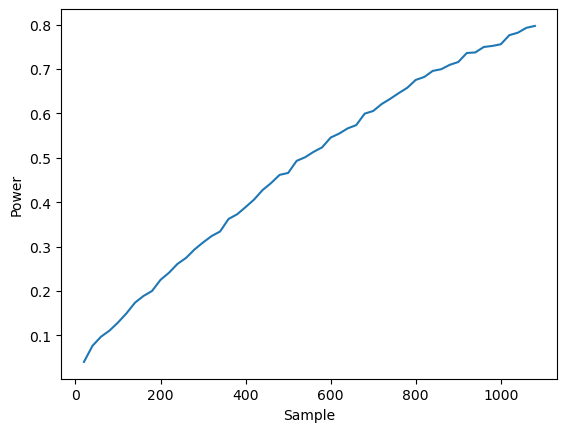

In [34]:
logit_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":logit_powers})
logit_results["Method"] = "Logistic regression"
sns.lineplot(data=logit_results, x="Sample", y="Power")

<Axes: xlabel='Sample', ylabel='Power'>

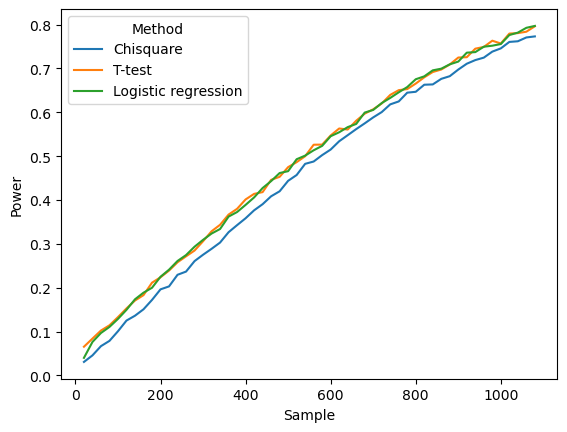

In [47]:
total_df = pd.concat([total_df, logit_results])

sns.lineplot(data=total_df, x="Sample", y="Power", hue="Method")

Судя по всему, для выборок одинакового размера мощность логистической регрессии сопоставима с мощностью t-теста! Хотя если присмотреться, то можно видеть проседание мощности на выборках малого размера - там логистическая регрессия выдавала предупреждения о том, что она не сошлась (т.е. не пришла к оптимальному решению). Видимо, для малых выборок с этим методом надо быть поосторожнее - он может потребовать более тонких настроек алгоритма, с помощью которого модель подбирает коэффициенты.

#### FPR

In [35]:
logit_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    logit_fpr.append(logit_power(conv_control=0.2, conv_test=0.2, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

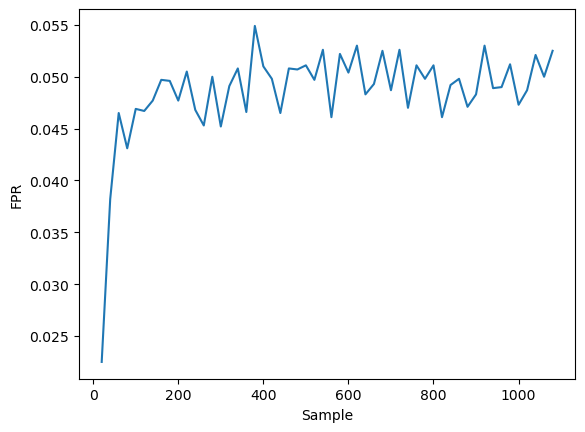

In [36]:
logit_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":logit_fpr})
logit_fpr_results["Method"] = "Logistic regression"
sns.lineplot(data=logit_fpr_results, x="Sample", y="FPR")

<Axes: xlabel='Sample', ylabel='FPR'>

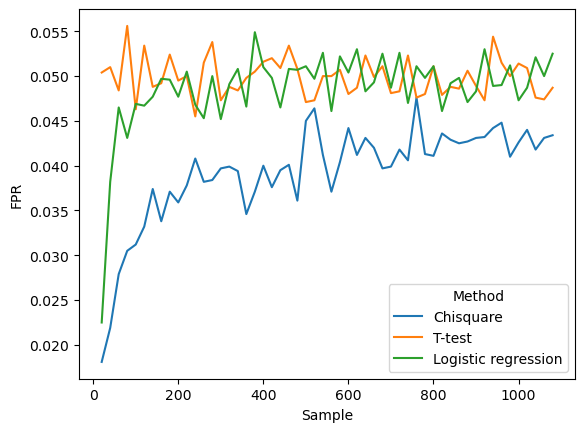

In [48]:
total_fpr_df = pd.concat([total_fpr_df, logit_fpr_results])

sns.lineplot(data=total_fpr_df, x="Sample", y="FPR", hue="Method")

Опять же, результаты сопоставимы с t-тестом, но на малых выборках логистическая регрессия становится консервативной. Скорее всего, это следствие наблюдения выше (о плохой сходимости метода).

#### Мощность (неравные выборки)

In [37]:
def logit_power_uneq(conv_control, conv_test, sample_size, test_prop, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для логистической регрессии методом Монте-Карло 
    (независимые наблюдения, неравный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (контрольная группа)
    * test_prop - какую пропорцию составляет размер тестовой группы от размера контрольной
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=1, p=conv_control, size=sample_size) #данные контрольной группы
        test = rng.binomial(n=1, p=conv_test, size=round(sample_size*test_prop)) #данные тестовой группы

        #общая переменная с данными групп
        data = np.concatenate([control, test]) 
        #индикаторы принадлежности наблюдения к группе
        group = np.concatenate([np.repeat(0, repeats=sample_size), 
                                np.repeat(1, repeats=round(sample_size*test_prop))]) 

        #строим логистическую регрессию, извлекаем p-value
        #аргумент disp=False подавляет лишний вывод
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(sm.Logit(data, sm.add_constant(group)).fit(disp=False).pvalues[1] < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [38]:
power_logit_uneq = []

for prop in tqdm(props):

    power_logit_uneq.append(logit_power_uneq(conv_control=0.2, conv_test=0.25, sample_size=1000, 
                                             test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

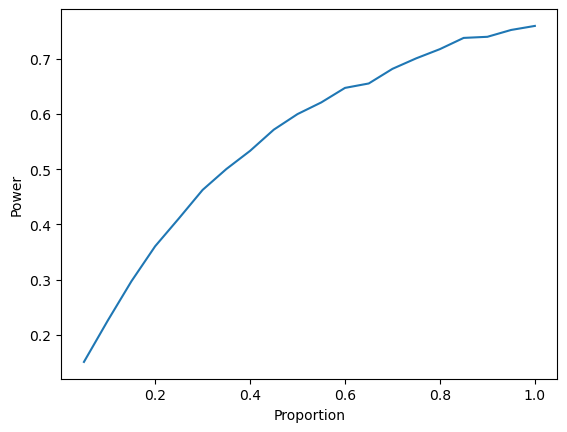

In [39]:
logit_uneq_results = pd.DataFrame({"Proportion":props, "Power":power_logit_uneq})
logit_uneq_results["Method"] = "Logistic regression (uneq. samples)"
sns.lineplot(data=logit_uneq_results, x="Proportion", y="Power")

<Axes: xlabel='Proportion', ylabel='Power'>

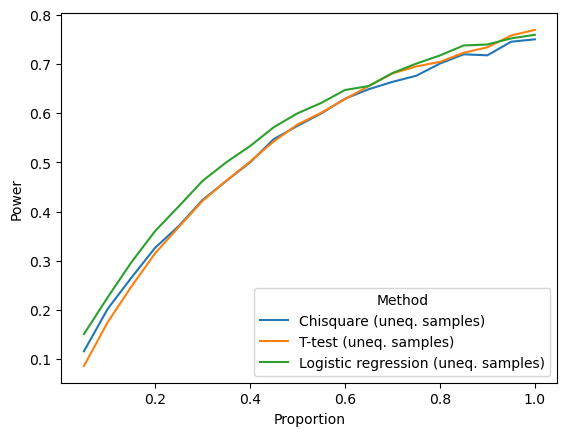

In [49]:
total_df_uneq = pd.concat([total_df_uneq, logit_uneq_results])
sns.lineplot(data=total_df_uneq, x="Proportion", y="Power", hue="Method")

Несмотря на то, что логистическая регрессия всё так же подвержена потерям мощности при диспропорции в выборках, её это затрагивает гораздо меньше - она легко переплёвывает и t-тест, и хи-квадрат по мощности! Похоже, у нас новый победитель для ситуаций с неравным размером выборки.

#### FPR (неравные выборки)

In [40]:
fpr_logit_uneq = []

for prop in tqdm(props):

    fpr_logit_uneq.append(logit_power_uneq(conv_control=0.2, conv_test=0.2, sample_size=1000, 
                                           test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

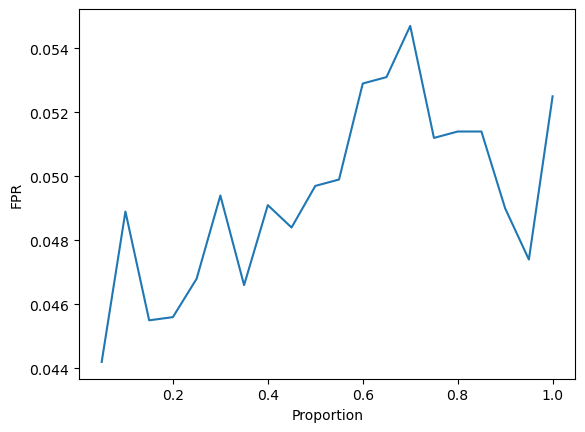

In [41]:
logit_uneq_fpr = pd.DataFrame({"Proportion":props, "FPR":fpr_logit_uneq})
logit_uneq_fpr["Method"] = "Logistic regression (uneq. samples)"
sns.lineplot(data=logit_uneq_fpr, x="Proportion", y="FPR")

<Axes: xlabel='Proportion', ylabel='FPR'>

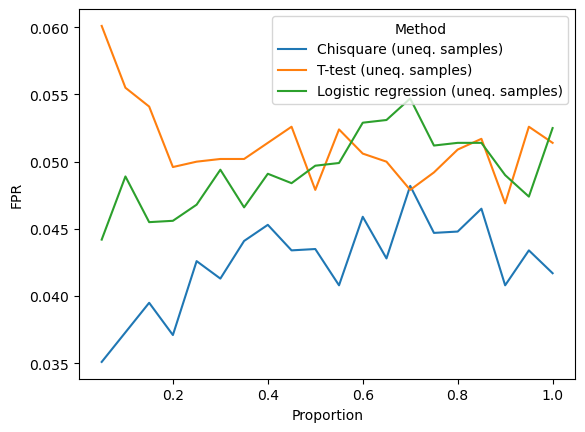

In [50]:
total_fpr_uneq = pd.concat([total_fpr_uneq, logit_uneq_fpr])
sns.lineplot(data=total_fpr_uneq, x="Proportion", y="FPR", hue="Method")

Здесь видно, что логистическая регрессия контролирует ошибку I рода так же, как и t-тест, но эта вероятность скорее падает с ростом диспропорции, чем уменьшается. Впрочем, виден довольно сильный разброс значений - возможно, в будущем стоит провести большее количество симуляций для более точной оценки.

### 6.2 Пуассон-регрессия

Замечали ли вы, что в биномиальном распределении нам нужно чётко указывать, сколько у нас было попыток? Реальный мир часто не такой - в нём количество попыток бесконечно! Поэтому в какой-то момент было открыто распределение, которое ведёт себя так же, как и биномиальное, но предполагает очень малую вероятность успеха и бесконечное количество попыток. Называется оно **распределением Пуассона**:

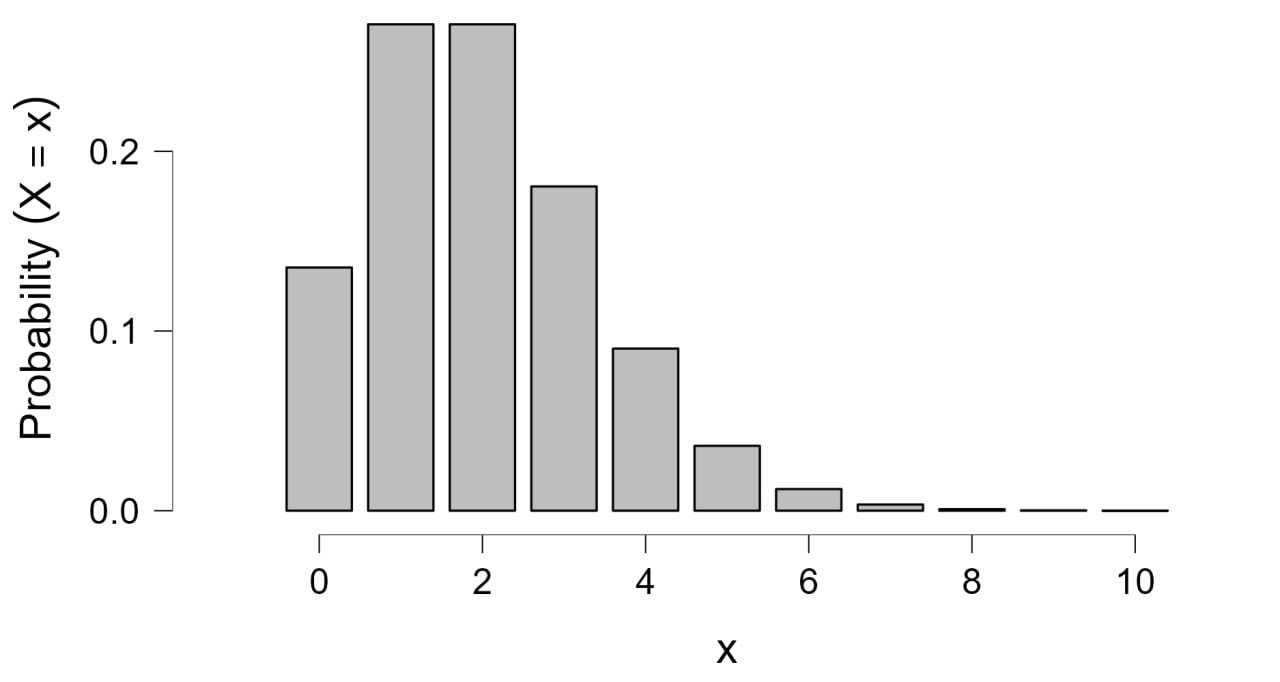

Чтобы понять его связь с биномиальным распределением, нужно для начала уточнить, как работает биномиальное распределение. Про распределение Пуассона - для этого надо понять сначала, как работает биномиальное распределение.

Напомню, что биномиальное распределение отражает количество успехов и имеет два параметра:

- $n$ - количество проб, успешных и неуспешных
- $p$ - вероятность успеха

Среднее в таком распределении является просто результатом умножения этих двух параметров - $np$. Оно и понятно - чем выше вероятность успеха (=конверсия), тем больше успехов; но и чем выше проб (=количество посетителей сайта), тем больше успехов.

Также это означает, что мы можем получить одно и то же среднее, пропорционально меняя оба параметра в разном направлении: $n=10, p=0.5$ => $n=100, p=0.05$ => $n=1000, p = 0.005$. 


Распределение Пуассона - это доведение этой идеи до её логического (и математического) предела. Это то, что получается, когда параметр $n$ становится бесконечно большим, а параметр $p$ - бесконечно малым. Иными словами, распределение Пуассона описывает такие процессы, когда исследуемое событие очень редкое, но возможностей произойти у него очень много. 

> Классический пример - количество землетрясений в Японии в течение N лет. Вероятность землетрясения в целом не очень высокая, но за N лет оно могло начаться буквально в любой момент.

Если судить по [блогпосту с линейными моделями](https://lindeloev.github.io/tests-as-linear/), то обобщённая линейная модель, предполагающая распределение Пуассона, является прямым аналогом хи-квадрата! Для этого нужно просто привести наши данные в нужную для модели форму и указать правильную спецификацию этой модели:

### 6.2 Пуассон-регрессия

Замечали ли вы, что в биномиальном распределении нам нужно чётко указывать, сколько у нас было попыток? Реальный мир часто не такой - в нём количество попыток бесконечно! Поэтому в какой-то момент было открыто распределение, которое ведёт себя так же, как и биномиальное, но предполагает очень малую вероятность успеха и бесконечное количество попыток. Называется оно **распределением Пуассона**:

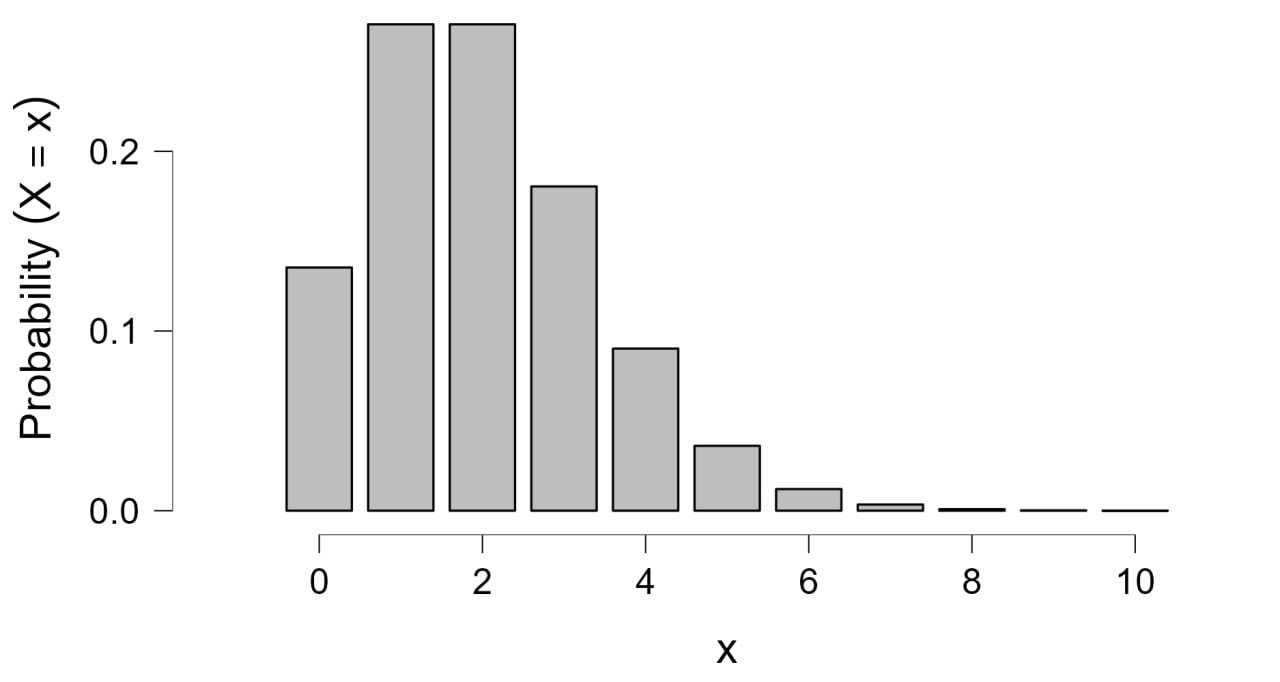

Чтобы понять его связь с биномиальным распределением, нужно для начала уточнить, как работает биномиальное распределение. Про распределение Пуассона - для этого надо понять сначала, как работает биномиальное распределение.

Напомню, что биномиальное распределение отражает количество успехов и имеет два параметра:

- $n$ - количество проб, успешных и неуспешных
- $p$ - вероятность успеха

Среднее в таком распределении является просто результатом умножения этих двух параметров - $np$. Оно и понятно - чем выше вероятность успеха (=конверсия), тем больше успехов; но и чем выше проб (=количество посетителей сайта), тем больше успехов.

Также это означает, что мы можем получить одно и то же среднее, пропорционально меняя оба параметра в разном направлении: $n=10, p=0.5$ => $n=100, p=0.05$ => $n=1000, p = 0.005$. 


Распределение Пуассона - это доведение этой идеи до её логического (и математического) предела. Это то, что получается, когда параметр $n$ становится бесконечно большим, а параметр $p$ - бесконечно малым. Иными словами, распределение Пуассона описывает такие процессы, когда исследуемое событие очень редкое, но возможностей произойти у него очень много. 

> Классический пример - количество землетрясений в Японии в течение N лет. Вероятность землетрясения в целом не очень высокая, но за N лет оно могло начаться буквально в любой момент.

Если судить по [блогпосту с линейными моделями](https://lindeloev.github.io/tests-as-linear/), то обобщённая линейная модель, предполагающая распределение Пуассона, является прямым аналогом хи-квадрата! Для этого нужно просто привести наши данные в нужную для модели форму и указать правильную спецификацию этой модели: спецификацию этой модели:

In [31]:
#считаем количества успехов и неудач

poiss_outcome = [control.sum(), control.size - control.sum(), test.sum(), test.size - test.sum()]
poiss_outcome

[187, 813, 280, 720]

In [32]:
#для наглядности запихиваем это в датафрейм

poiss_df = pd.DataFrame({"Group": ["control", "control", "test", "test"], 
                         "Outcome": ["hit", "miss", "hit", "miss"], "Freq": poiss_outcome})
poiss_df

,Group,Outcome,Freq
0,control,hit,187
1,control,miss,813
2,test,hit,280
3,test,miss,720


Как же нам закодировать эти переменные, чтобы была понятна их связь с количествами? В этом нам поможет библиотека `patsy`, лежащая в основе "формульного" API `statsmodels`. Кто не знает - [формульный синтаксис](https://www.econometrics.blog/post/the-r-formula-cheatsheet/) является родным для языка R, и там с помощью него задаются регрессионные модели. `patsy` - это попытка адаптировать такой синтаксис для Python.

Для начала попробуем вот такую формулу:

$$Freq \sim 1 + Group + Outcome$$

Как её читать?

1. Знак `~` разделяет зависимые и независимые переменные. В данном случае мы смотрим на то, как значение переменной Freq (зависимая) связано со всеми остальными (независимые)
2. `1` обозначает свободный член
3. Знак `+` означает, что конкретная переменная имеет аддитивный характер, т.е. она не имеет каких-то взаимосвязей с остальными независимыми переменными.

Давайте глянем, что получится:

In [33]:
endog, exog = patsy.dmatrices("Freq ~ 1 + Group + Outcome", poiss_df)
print(endog)
print(exog)

[[187.]
 [813.]
 [280.]
 [720.]]
[[1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]


Функция выдала нам две матрицы - первая для зависимой переменной, вторая - для свободного члена + двух независимых переменных. Их мы и будем использовать.

> Вторая матрица называются дизайн-матрицей; подобные матрицы задают значения независимых переменных и их взаимосвязи с зависимыми. Их можно найти под капотом всех современных регрессионных методов. 

In [34]:
poiss_res = sm.Poisson(endog, exog).fit()
poiss_res.summary()

Optimization terminated successfully.
         Current function value: 6.973675
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   Freq   No. Observations:                    4
Model:                        Poisson   Df Residuals:                        1
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Oct 2023   Pseudo R-squ.:                  0.9148
Time:                        20:18:05   Log-Likelihood:                -27.895
converged:                       True   LL-Null:                       -327.25
Covariance Type:            nonrobust   LLR p-value:                9.838e-131
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4532      0.051    106.106      0.000       5.352       5.554
Group[T.test]   -1.897e-16      0.045  -4.24e-15      1.000      -0.088       0.088
Outcome[T.miss]     1.1887      0.053     22.489      0.000       1.085       1.292
===================================================================================
"""

В данном случае трансформация переменных - это обыкновенный натуральный логарифм, и он откатывается обратно экспоненциацией:

In [37]:
print(np.exp(poiss_res.params[0]))
print(np.exp(poiss_res.params[0] + poiss_res.params[1]))
print(np.exp(poiss_res.params[0] + poiss_res.params[2]))
print(np.exp(poiss_res.params[0] + poiss_res.params[1] + poiss_res.params[2]))

233.50000000000003
233.50000000000003
766.5000000000001
766.5000000000001


Мы получили четыре числа, но что они означают? Ответ простой: первые два - это среднее количество успехов, вторые два - среднее количество неудач:

In [39]:
print(f"Среднее количество успехов: {np.mean([control.sum(), test.sum()])}")
print(f"Среднее количество неудач: {np.mean([control.size - control.sum(), test.size - test.sum()])}")

Среднее количество успехов: 233.5
Среднее количество неудач: 766.5


Коэффициенты и их значимость дают нам следующую информацию:

- `Group[T.test]` отражает то, как отличается количество событий в тестовой группе по сравнению с контрольной. P-value равен 1.0, то есть количество событий в группах одинаковое.
- `Group[T.miss]` отражает то, как отличается количество неудач по сравнению с успехами. Так как коэффициент положительный и статистически значимый, то мы можем заключить: недуач больше, чем успехов.

**Мы не получили никакой интересной информации!**. То. что количество событий в обоих групп одинаковое, мы и так знаем заранее - мы собираем группы одинакового размера, конечно же, в них будет одинаковое число событий! Второе наблюдение может быть полезно, если мы предполагаем 50%-ую конверсию в обоих группах, но в большинстве случаев тривиально.

Самое главное: мы не узнали, есть ли какая-то взаимосвязь между типом события (успех/неудача) и экспериментальной группой (контроль/тест)! И это непосредственно связано с тем, что эти две переменные мы указали как **независимые друг от друга** (помните пунктик про аддитивность?). Чтобы проверить, есть ли взаимосвязь между этими переменными, мы должны добавить **мультипликативное взаимодействие** в формулу - и делается это оператором `*`:

In [41]:
endog, exog = patsy.dmatrices("Freq ~ 1 + Group*Outcome", poiss_df)
print(endog)
print(exog)

[[187.]
 [813.]
 [280.]
 [720.]]
[[1. 0. 0. 0.]
 [1. 0. 1. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]]


Обратите внимание, что во второй матрице появился четвёртый столбец - он как раз отвечает за взаимодействие. 

In [42]:
poiss_res_2 = sm.Poisson(endog, exog).fit()
poiss_res_2.summary()

Optimization terminated successfully.
         Current function value: 3.937414
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   Freq   No. Observations:                    4
Model:                        Poisson   Df Residuals:                        0
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Oct 2023   Pseudo R-squ.:                  0.9519
Time:                        20:42:09   Log-Likelihood:                -15.750
converged:                       True   LL-Null:                       -327.25
Covariance Type:            nonrobust   LLR p-value:                1.043e-134
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.2311      0.073     71.534      0.000       5.088       5.374
Group[T.test]                     0.4037      0.094      4.274      0.000       0.219       0.589
Outcome[T.miss]                   1.4696      0.081     18.121      0.000       1.311       1.629
Group[T.test]:Outcome[T.miss]    -0.5252      0.107     -4.889      0.000      -0.736      -0.315
=================================================================================================
"""

Смотрите, как изменилась моделька! Посчитаем коэффициенты:

In [44]:
print(np.exp(poiss_res_2.params[0]))
print(np.exp(poiss_res_2.params[0] + poiss_res_2.params[1]))
print(np.exp(poiss_res_2.params[0] + poiss_res_2.params[2]))
print(np.exp(poiss_res_2.params[0] + poiss_res_2.params[1] + poiss_res_2.params[2] + poiss_res_2.params[3]))

187.00000000000003
280.00000000000017
813.0000000000003
720.0000000000001


Вот теперь все числа совпадают с теми, которые у нас есть в данных! Обратите внимание, что для расчёта числа неудач в тестовой группе нам пришлось добавить к константе не только значения коэффициентов `Group[T.test]` и `Outcome[T.miss]`, но и `Group[T.test]:Outcome[T.miss]` - это как раз и есть коэффициент взаимодействия.

Но это ещё не всё. Обратите внимание, что добавление коэффициента взаимодействия изменило вообще все коэффициенты модели - это значит, что мы не обойдёмся простым взятием p-value для этого коэффициента, чтобы понять значимость взаимосвязи! Чтобы сделать такой вывод, нам нужно *сравнить модели целиком*.

В этом нам поможет замечательный статистический тест, называемый [Likelihood Ratio Test](https://sites.warnercnr.colostate.edu/gwhite/wp-content/uploads/sites/73/2017/04/LikelihoodRatioTests.pdf)! С помощью такого теста можно сравнивать **вложенные модели** - т.е. модели того же типа, построенные на тех же данных, но с разной структурой. Соответственно, если мы получим достаточно низкое p-value, то это будет свидительствовать об отличиях в моделях - в нашем случае так можно показать, что добавление взаимодействия не оказалось бесполезным, а реально что-то изменило в модели.

По непонятным мне причинам этот тест не встроен в пуассон-регрессию в `statsmodels`, поэтому я утырил код [отсюда](https://stackoverflow.com/questions/23803236/likelihood-ratio-test-statsmodels):

In [45]:
def lr_test(full_model, null_model):

    #различие в правдоподобии
    lr_stat = -2 * (null_model.llf - full_model.llf)

    #различие в степенях свободы
    lr_df = null_model.df_resid - full_model.df_resid

    #возвращаем p-value (обратите внимание, на основе какого распределения оно считается!)
    return(st.chi2.sf(lr_stat, df=lr_df))

In [46]:
lr_test(poiss_res_2, poiss_res)

8.286451324827712e-07

В данном случае видим очень низкое p-value - а значит, свидетельство в пользу взаимосвязи, как мы и хотели! 

Вот это, конечно, сэтап для метода, который должен был заменять хи-квадрат... Давайте посмотрим, стоит ли это того.

#### Мощность

In [73]:
def poiss_power(conv_control, conv_test, sample_size, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для пуассоновской регрессии методом Монте-Карло 
    (независимые наблюдения, равный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (одна группа)
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #создаём дизайн-матрицу для двух моделей - нулевой и полной
    exog_null = np.array([[1., 0., 0.], 
                          [1., 0., 1.], 
                          [1., 1., 0.], 
                          [1., 1., 1.]])
    exog_full = np.array([[1., 0., 0., 0.], 
                          [1., 0., 1., 0.], 
                          [1., 1., 0., 0.], 
                          [1., 1., 1., 1.]])

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        #создаём количество успехов и неудач для контроля и теста
        control = rng.binomial(n=sample_size, p=conv_control, size=1)[0] #данные контрольной группы
        test = rng.binomial(n=sample_size, p=conv_test, size=1)[0] #данные тестовой группы


        data = [control, sample_size-control, test, sample_size-test] #общая переменная с данными групп

        #строим пуассоновскую регрессию для нулевой и полной модели
        #аргумент disp=False подавляет лишний вывод
        #сравниваем правдоподобия и извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        null = sm.Poisson(data, exog_null).fit(disp=False)
        full = sm.Poisson(data, exog_full).fit(disp=False)
        pvals.append(lr_test(full, null) < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Когда я запускал этот код в первый раз, для маленькой выборки он просто отказался считаться. Я мог бы поиграться с настройками алгоритма, которым модель подбирает коэффициенты, но я решил подойти к вопросу проще - начать отсчёт с более крупного размера выборки (100 наблюдений):

In [76]:
poiss_res = poiss_power(conv_control=0.2, conv_test=0.25, sample_size=1000, num_iter=10000, rng=rng)
print(f"Значение мощности: {poiss_res}")

Значение мощности: 0.7672


In [77]:
poiss_powers = []

for sample_size in tqdm(range(100, 1100, 20)):

    poiss_powers.append(poiss_power(conv_control=0.2, conv_test=0.25, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

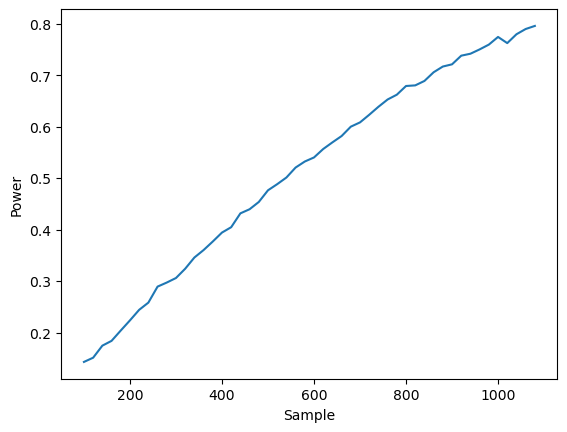

In [78]:
poiss_results = pd.DataFrame({"Sample":list(range(100, 1100, 20)), "Power":poiss_powers})
poiss_results["Method"] = "Poisson regression"
sns.lineplot(data=poiss_results, x="Sample", y="Power")

<Axes: xlabel='Sample', ylabel='Power'>

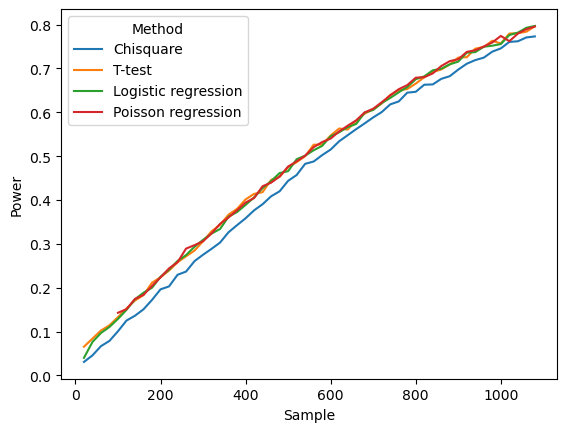

In [80]:
total_df = pd.concat([total_df, poiss_results])

sns.lineplot(data=total_df, x="Sample", y="Power", hue="Method")

Мощность ровно такая же, как у t-теста и логистической регрессии. Это интересно: значит, не настолько уж хи-квадрат и пуассон-регрессия взаимозаменяемы! Пуассон-регрессия явно более удачный вариант, если у вас не маленькая выборка (где он может отказаться считаться).

#### FPR

In [81]:
poiss_fpr = []

for sample_size in tqdm(range(100, 1100, 20)):

    poiss_fpr.append(poiss_power(conv_control=0.2, conv_test=0.2, sample_size=sample_size, num_iter=10000, rng=rng))

  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

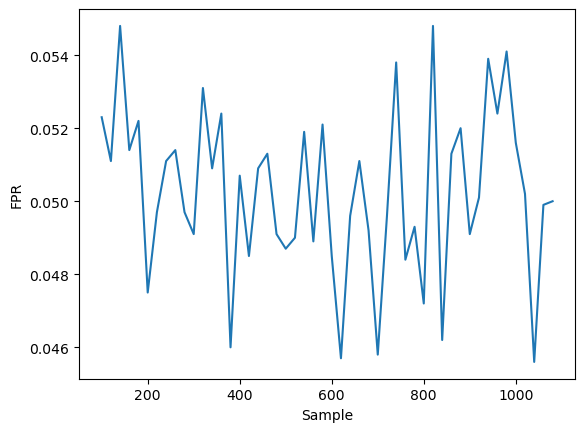

In [82]:
poiss_fpr_results = pd.DataFrame({"Sample":list(range(100, 1100, 20)), "FPR":poiss_fpr})
poiss_fpr_results["Method"] = "Poisson regression"
sns.lineplot(data=poiss_fpr_results, x="Sample", y="FPR")

<Axes: xlabel='Sample', ylabel='FPR'>

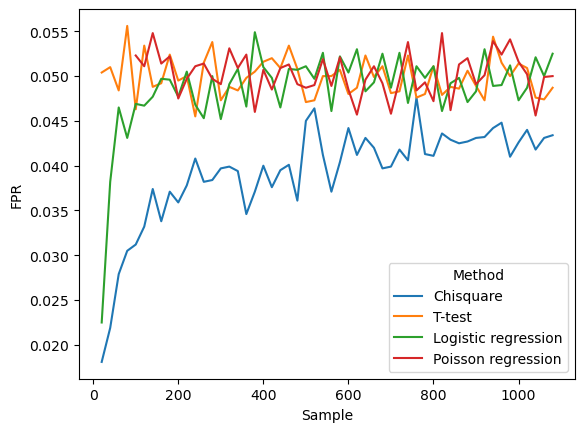

In [83]:
total_fpr_df = pd.concat([total_fpr_df, poiss_fpr_results])

sns.lineplot(data=total_fpr_df, x="Sample", y="FPR", hue="Method")

С контролем ошибки I рода ситуация такая же, всё как и обещано. Идём дальше.

#### Мощность (неравные выборки)

In [84]:
def poiss_power_uneq(conv_control, conv_test, sample_size, test_prop, num_iter, rng, alpha=0.05):

    '''
    Функция считает мощность для логистической регрессии методом Монте-Карло 
    (независимые наблюдения, неравный размер групп).

    * conv_control - значение конверсии в контрольной группе
    * conv_test - значение конверсии в тестовой группе
    * sample_size - размер выборки (контрольная группа)
    * test_prop - какую пропорцию составляет размер тестовой группы от размера контрольной
    * num_iter - количество симуляций Монте-Карло
    * rng - генератор случайных чисел
    * alpha - уровень значимости (по умолчанию 0.05)
    
    '''

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)

    #создаём дизайн-матрицу для двух моделей - нулевой и полной
    exog_null = np.array([[1., 0., 0.], 
                          [1., 0., 1.], 
                          [1., 1., 0.], 
                          [1., 1., 1.]])
    exog_full = np.array([[1., 0., 0., 0.], 
                          [1., 0., 1., 0.], 
                          [1., 1., 0., 0.], 
                          [1., 1., 1., 1.]])

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = rng.binomial(n=sample_size, p=conv_control, size=1) #данные контрольной группы
        test = rng.binomial(n=round(sample_size*test_prop), p=conv_test, size=1) #данные тестовой группы

        data = [control, sample_size-control, test, round(sample_size*test_prop)-test] #общая переменная с данными групп

        #строим пуассоновскую регрессию для нулевой и полной модели
        #аргумент disp=False подавляет лишний вывод
        #сравниваем правдоподобия и извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        null = sm.Poisson(data, exog_null).fit(disp=False)
        full = sm.Poisson(data, exog_full).fit(disp=False)
        pvals.append(lr_test(full, null) < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

In [85]:
power_poiss_uneq = []

for prop in tqdm(props):

    power_poiss_uneq.append(poiss_power_uneq(conv_control=0.2, conv_test=0.25, sample_size=1000, 
                                             test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

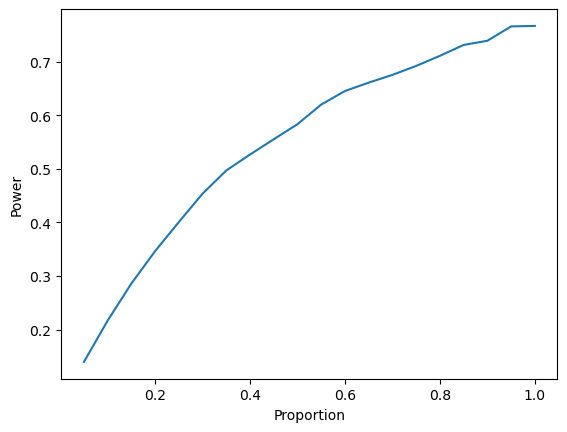

In [86]:
poiss_uneq_results = pd.DataFrame({"Proportion":props, "Power":power_poiss_uneq})
poiss_uneq_results["Method"] = "Poisson regression (uneq. samples)"
sns.lineplot(data=poiss_uneq_results, x="Proportion", y="Power")

<Axes: xlabel='Proportion', ylabel='Power'>

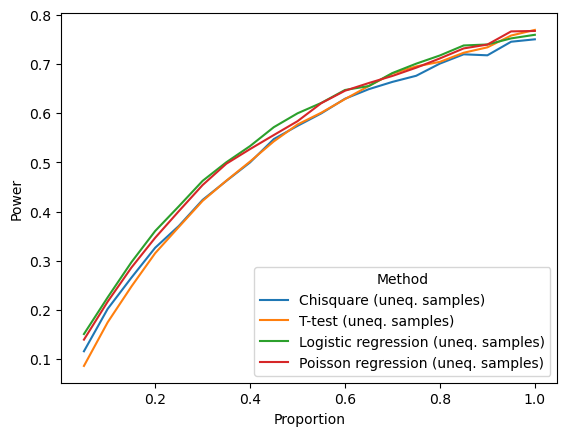

In [87]:
total_df_uneq = pd.concat([total_df_uneq, poiss_uneq_results])
sns.lineplot(data=total_df_uneq, x="Proportion", y="Power", hue="Method")

Результаты сравнимы с логистической - может, самую чуточку ниже для очень сильного дисбаланса.

#### FPR (неравные выборки)

In [88]:
fpr_poiss_uneq = []

for prop in tqdm(props):

    fpr_poiss_uneq.append(poiss_power_uneq(conv_control=0.2, conv_test=0.2, sample_size=1000, 
                                           test_prop=prop, num_iter=10000, rng=rng))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

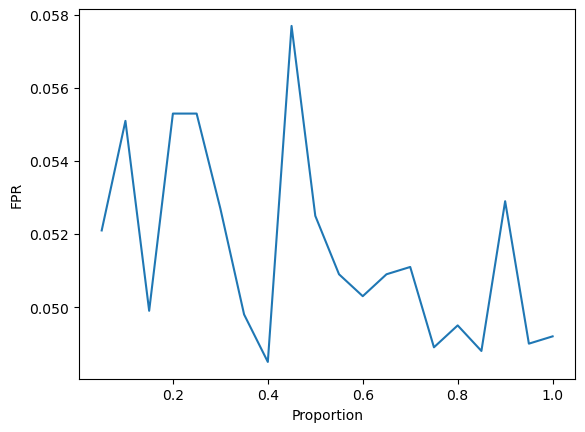

In [89]:
poiss_uneq_fpr = pd.DataFrame({"Proportion":props, "FPR":fpr_poiss_uneq})
poiss_uneq_fpr["Method"] = "Poisson regression (uneq. samples)"
sns.lineplot(data=poiss_uneq_fpr, x="Proportion", y="FPR")

<Axes: xlabel='Proportion', ylabel='FPR'>

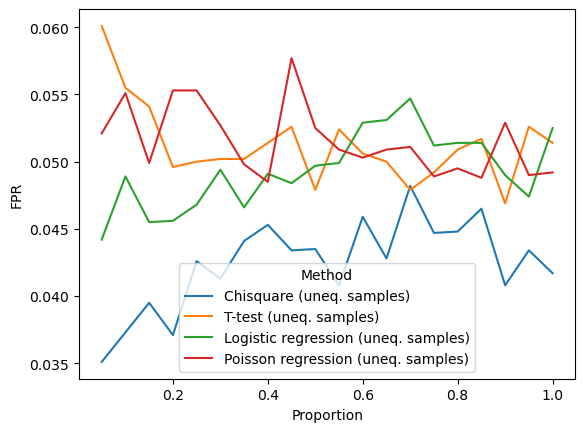

In [90]:
total_fpr_uneq = pd.concat([total_fpr_uneq, poiss_uneq_fpr])
sns.lineplot(data=total_fpr_uneq, x="Proportion", y="FPR", hue="Method")

Выглядит так, словно FPR чуточку растёт при увеличении диспропорции и это происходит раньше, чем у t-теста (но при этом не настолько радикально). В будущем надо будет посимулировать их дополнительно с большим числом симуляций.

## Итоги

Что мы в итоге можем сказать о каждом тесте в контексте конверсии?

- **T-тест**: очень хороший вариант по умолчанию, дающий быстро и дешёво приличную мощность. Если вам не нужны какие-то сложные модели и дополнительная информация, а ваши выборки не сильно отличаются по размерам - смело используйте.
- **Хи-квадрат**: очень консервативный тест, которому явно не хватает мощности. Если вы реально ненавидите ошибки I рода или разделяете особую любовь к табличкам сопряжённости - можете его взять, в остальных случаях не рекомендуется.
- **Логистическая регрессия**: если вам не нужен тот вагон дополнительной информации и гибкости, которую может дать эта модель, а выборки равные по размеру - особого смысла нет. Однако если выборки у вас различаются по размерам, то логистическая регрессия - рекомендация номер 1.
- **Пуассон-регрессия**: фактически хи-квадрат, но лучше. Какой-то особой причины использовать его по сравнению с t-тестом и логистической регрессией, впрочем нет - плюс у неё сомнительный FPR при разных размерах выборки. Стоит потом проверить дополнительно.

**NB!** В любом случае каждый тест стоит дополнительно проверять для той рабочей ситуации, в которой вы оказались - возможно, ваше конкретное сочетание показателей обнаружит такую закономерность, которую не показал этот пет-проект!